In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

In [2]:
warnings.filterwarnings("ignore")

In [3]:
price = pd.read_csv('backtest_17etfs.csv',index_col=0)
price = pd.pivot_table(price,'adj_close','date','code').ffill()
price.index = pd.to_datetime(price.index)
ret = price.pct_change()

In [4]:

name_list = ['sim 1.4.3 agg',
             'sim 1.4.3 mod',
             'sim 1.4.3 ficon',
             'sim 1.4.3 con',
            ]

excel_list = ['digital_twins_KPIs_sim20211116_agg.xlsx',
              'digital_twins_KPIs_sim20211116_mod.xlsx',
              'digital_twins_KPIs_sim20211116_ficon.xlsx',
              'digital_twins_KPIs_sim20211116_con.xlsx',
             ]
'''

name_list = ['17etf bound0 pc0 2016']

excel_list = ['digital_twins_KPIs_sim_bound0_agg.xlsx']
'''


"\n\nname_list = ['17etf bound0 pc0 2016']\n\nexcel_list = ['digital_twins_KPIs_sim_bound0_agg.xlsx']\n"

In [5]:
def plot_stack(df, sorted_index=None, title='', figsize=(16,9)):
    
    if sorted_index is None:
        sorted_index = df.sum().sort_values().index
    
    cm = plt.get_cmap('tab20')
    NUM_COLORS = len(sorted_index)
    color = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]
    
    
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)

    ax.set_prop_cycle(color=color[::-1])
    df1 = df.reindex(sorted_index[::-1], axis=1).applymap(lambda x: x if x>=0 else np.nan).fillna(0)
    df1.plot.area(ax=ax, linewidth=0)


    ax.set_prop_cycle(color=color)
    df0 = df.reindex(sorted_index, axis=1).applymap(lambda x: x if x<0 else np.nan)
    df0 = df0.rename(columns=lambda x: '_' + x)
    df0.plot.area(ax=ax, linewidth=0)


    pad = (df1.sum(axis=1).max() - df0.sum(axis=1).min())/20
    ax.set_ylim([df0.sum(axis=1).min()-pad, df1.sum(axis=1).max()+pad])
    
    
    df.sum(1).plot(ax=ax, style='k', linewidth=0.5, label='net')
    
    
    ax.set_title(title)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [6]:
def plot_all(excel_file_name, ret, ini='2007', start='2008', end='2021', name=''):
    
    result = {}
    
    kpi = pd.read_excel(excel_file_name, sheet_name='KPI', index_col=0)
    ykpi = pd.read_excel(excel_file_name, sheet_name='KPI(Annually)', index_col=0)
    mkpi = pd.read_excel(excel_file_name, sheet_name='KPI(Monthly)', index_col=0)
    dkpi = pd.read_excel(excel_file_name, sheet_name='KPI(Daily)', index_col=0)
    
    allo = pd.read_excel(excel_file_name, sheet_name='History', index_col=0)
    allo = allo.drop(['cash','debit','aum','lev_cost','perf','commissions','asset','asset_gross'], 1)

    try:
        balance_ini = allo[ini].Balance.iloc[-1]
    except:
        balance_ini = 1e9
    allo = allo[start:end]
    
    balance_open = allo.Balance.shift().fillna(balance_ini)
    
    asset_value_close = allo.drop(['Balance'], 1)
    if int(end[:4]) < 2016:
        asset_value_close = asset_value_close.drop(['FSP','LSP','OSP','PC0',], 1)
        ret = ret.drop(['FSP','LSP','OSP','PC0',], 1)
    
    idx_allo = asset_value_close.index
    idx_ret = ret.index

    idx_common = list(set(idx_allo) & set(idx_ret))
    idx_common.sort()

    asset_value_close = asset_value_close.reindex(idx_common)
    ret_ = ret.reindex(idx_common)

    asset_value_open = asset_value_close/(1+ret_)
    asset_value_diff = asset_value_close - asset_value_open

    
    net_cum_ret = (1+ret_).cumprod()-1
    net_ret = (1+ret_).prod()-1
    net_ret.sort_values()
    
    
    net_aml_ret = asset_value_diff/balance_ini
    net_aml_cum_ret = net_aml_ret.cumsum()
    net_aml_total_ret = net_aml_ret.sum()
    net_aml_total_ret.sort_values()
    
    lev = pd.concat([(asset_value_open[a]/balance_open) for a in ret.columns], 1, keys=ret.columns)
    
    weighted_aml_ret = net_aml_ret / lev.mean()
    weighted_aml_cum_ret = weighted_aml_ret.cumsum()
    weighted_aml_total_ret = weighted_aml_ret.sum()
    weighted_aml_total_ret.sort_values()
    
    
    change_comp = pd.concat([net_ret, net_aml_total_ret, weighted_aml_total_ret],1,
          keys=['net_ret', 'net_aml_ret', 'weighted_aml_ret']).sort_index()
    title = '{} to {}'.format(start, end)
    change_comp.sort_values('net_aml_ret').plot.bar(figsize=(16,9), title=name+' '+title)
    
    
    daily_df_dict = {}
    for a in ret.columns:
        daily_df_dict[a] = pd.concat([net_cum_ret[a], net_aml_cum_ret[a], weighted_aml_cum_ret[a]],1,
              keys=['net_cum_ret', 'net_aml_cum_ret', 'weighted_aml_cum_ret'])
        ax = daily_df_dict[a][['net_cum_ret', 'weighted_aml_cum_ret']].plot(figsize=(12,6), title=a)
        ax.set_ylabel("cumulative return")
        ax.legend(loc='center right', bbox_to_anchor=(0, 1))
    
        twinx = ax.twinx()
        lev[a].plot(ax=twinx, style='r--', label='lev', alpha=0.3)
        twinx.set_ylabel("leverage")
        twinx.legend(loc='center left', bbox_to_anchor=(1, 1))
    
    
    
    # plot aml_cum_ret (stacked)
    
    net_aml_cum_ret_df = pd.DataFrame({a:daily_df_dict[a]['net_aml_cum_ret'] for a in ret.columns}).fillna(0)
    #net_aml_cum_ret_df.plot(figsize=(16,9), title=name+' cumulative aml return')
    
    plot_stack(net_aml_cum_ret_df, title=name+' cumulative aml return (stacked)')
    
    
    
    
    
    # draw down
    
    dkpi_dd = dkpi['Draw Down']
    #dkpi_dd.plot(figsize=(16,9), title='dd')
    
    dkpi_dd_all_neg = dkpi_dd[dkpi_dd<0]
    dd_idx = dkpi_dd_all_neg.index

    dkpi_dd_all_shift_neg = dkpi_dd[dkpi_dd.shift()<0]
    dd_idx_shift = dkpi_dd_all_shift_neg.index
    
    dd_idx_recover1 = list(set(dd_idx_shift)|set(dd_idx))
    dd_idx_recover1.sort()
    
    net_aml_diff = net_aml_cum_ret_df.diff()
    net_aml_diff_ = net_aml_diff.divide(balance_open/balance_ini,0)
    #net_aml_diff_
    
    net_aml_dd = net_aml_diff_.reindex(dd_idx_recover1)
    
    aml_dd = pd.DataFrame(columns=net_aml_dd.columns)
    ini = pd.Series(0, index=net_aml_dd.columns)
    tmp = ini
    for idx in dd_idx_recover1:
        tmp = tmp + (net_aml_dd.loc[idx])

        if tmp.sum()>=0:
            tmp = ini

        aml_dd.loc[idx] = tmp

    #aml_dd.sum(1).plot(figsize=(16,9))

    plot_stack(aml_dd, title=name+' draw down (stacked)')
    
    
    
    
    
    
    result['balance'] = allo.Balance
    result['kpi'] = kpi
    result['ykpi'] = ykpi
    result['mkpi'] = mkpi
    result['dkpi'] = dkpi
    result['lev'] = lev
    result['net_aml_cum_ret_df'] = net_aml_cum_ret_df
    
    return result


In [7]:
result_all = {}

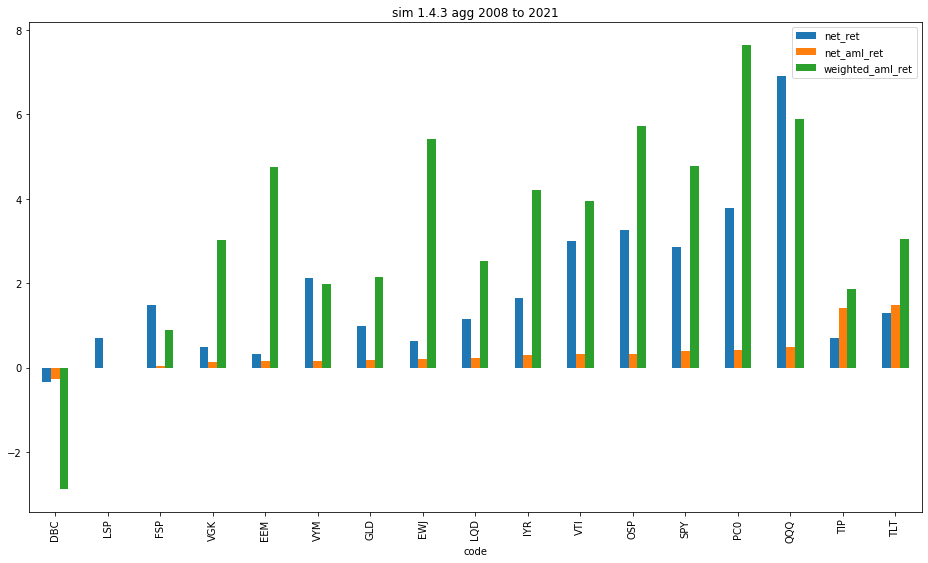

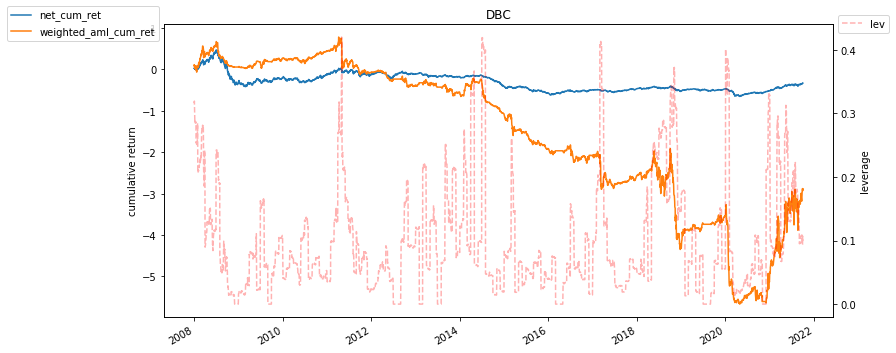

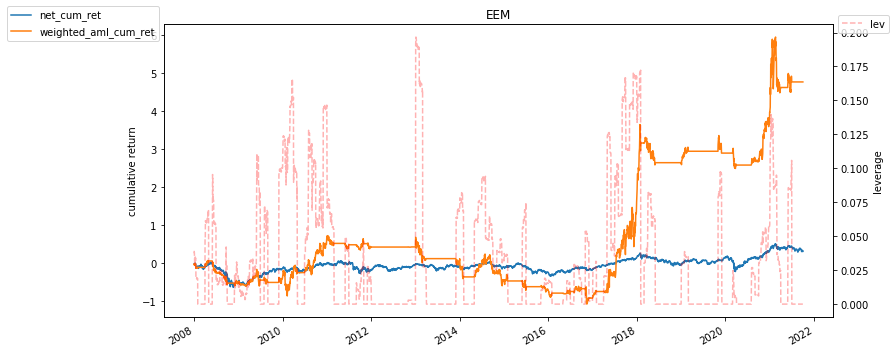

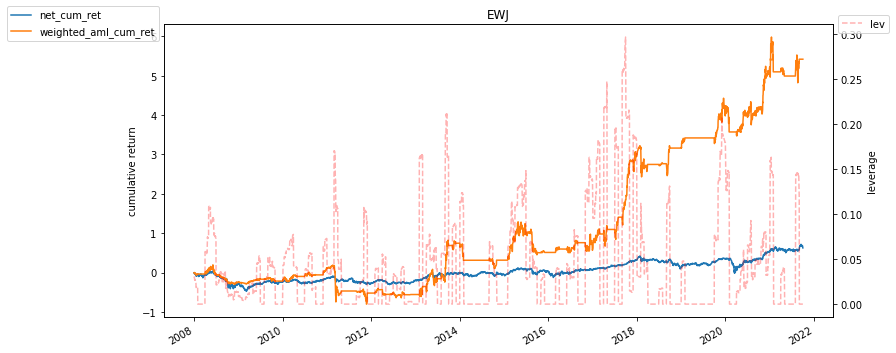

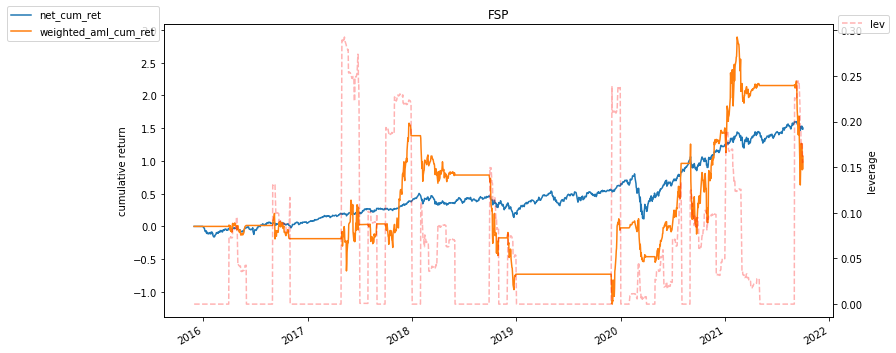

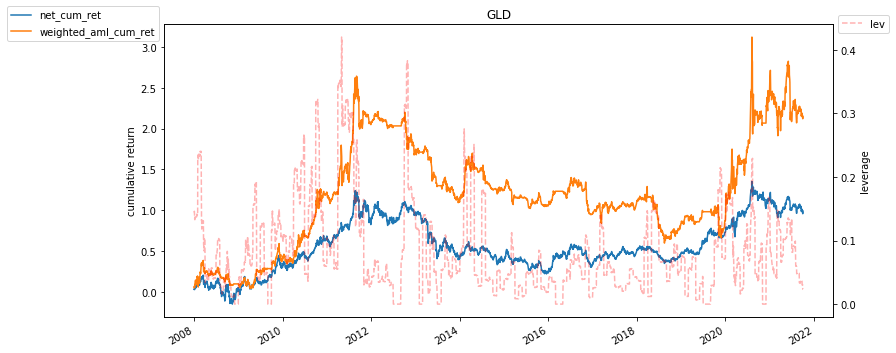

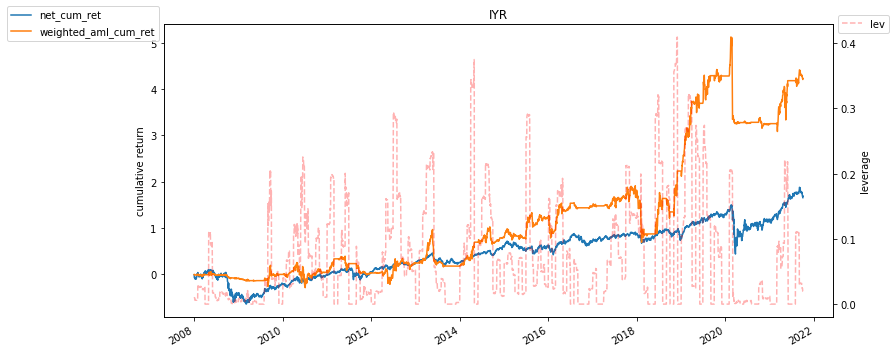

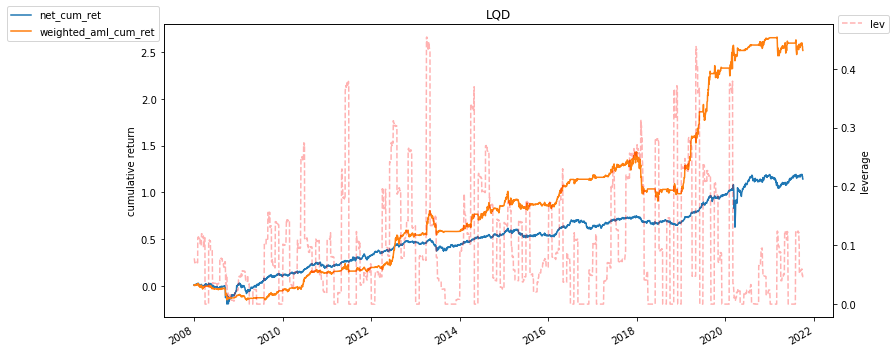

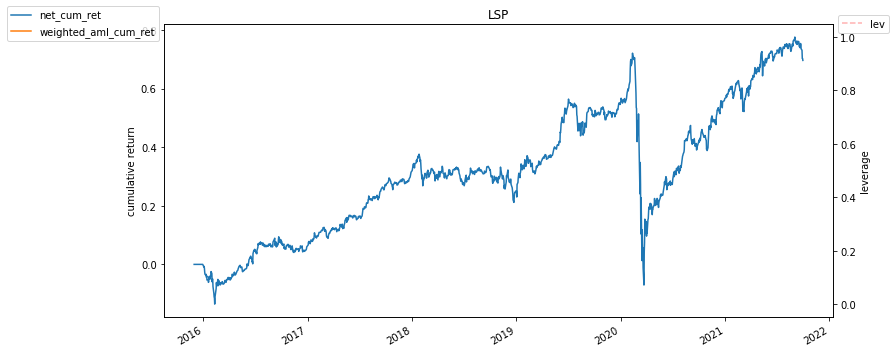

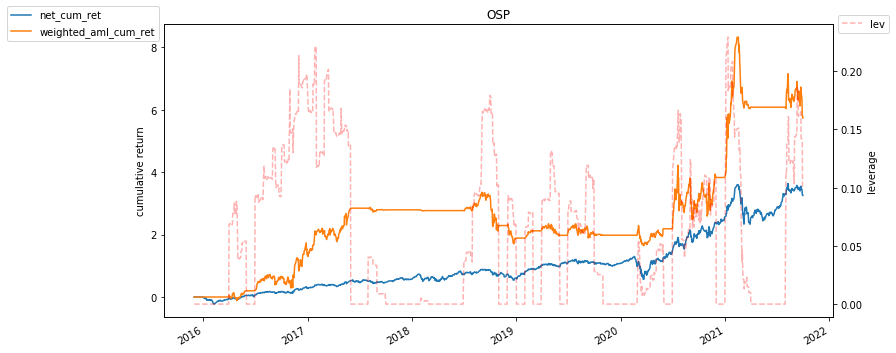

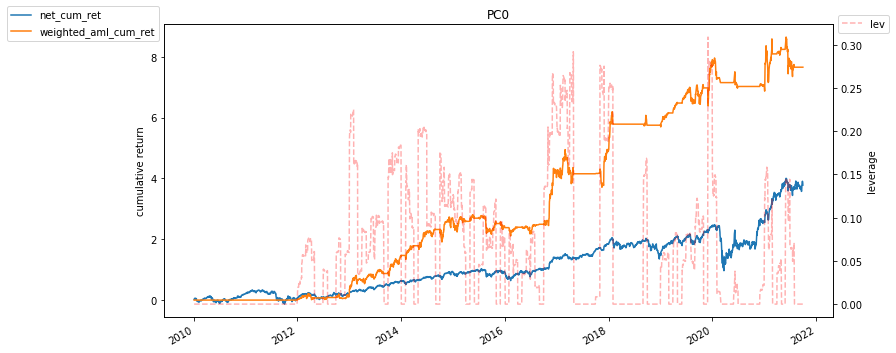

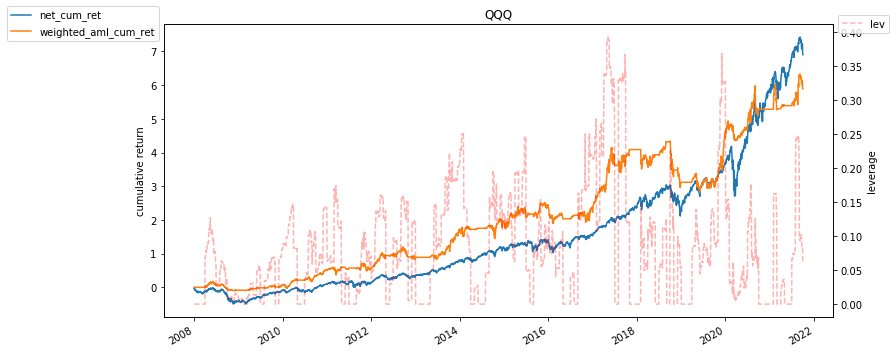

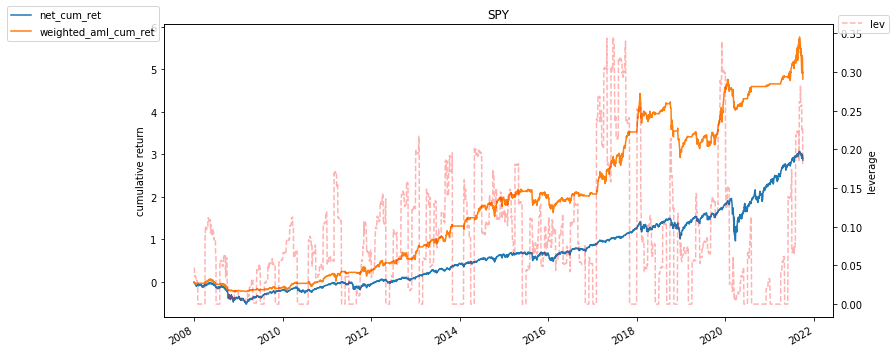

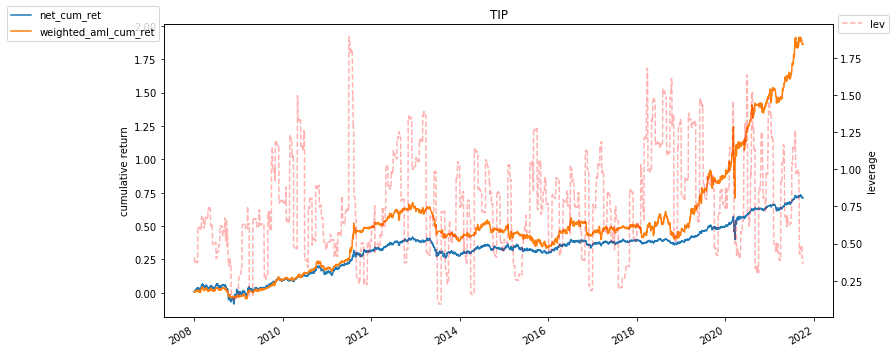

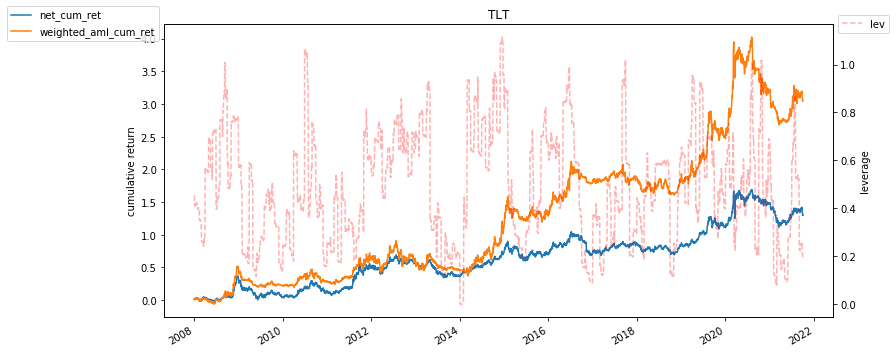

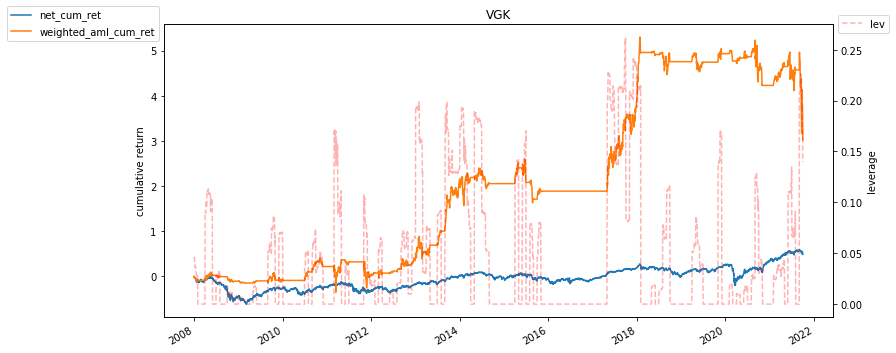

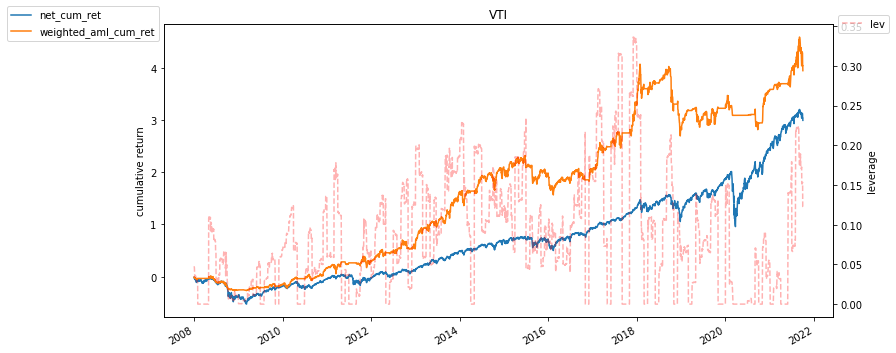

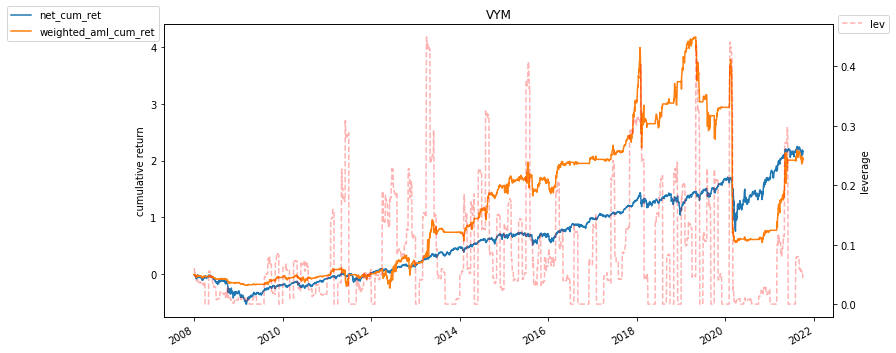

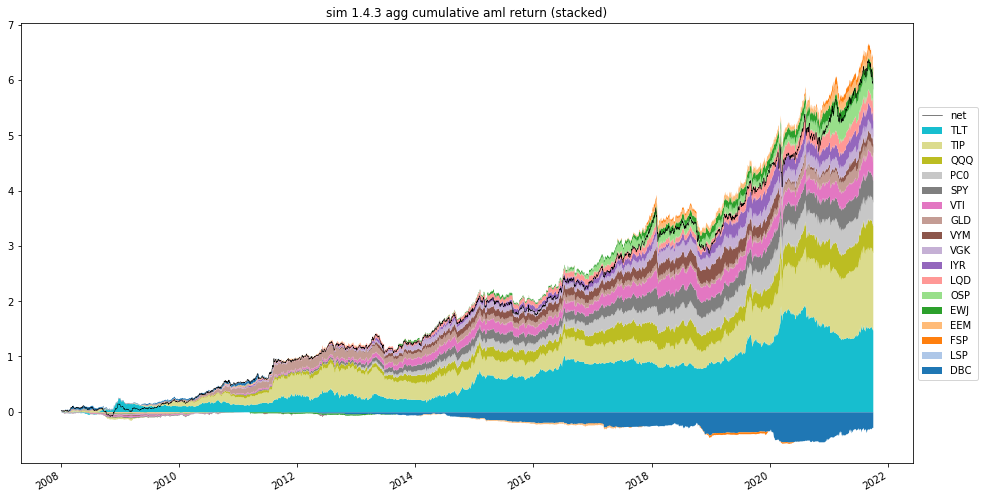

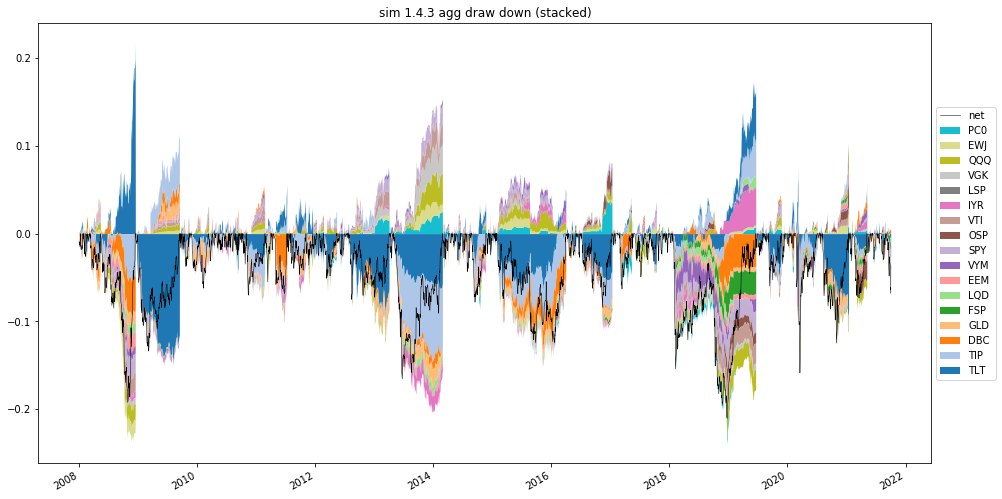

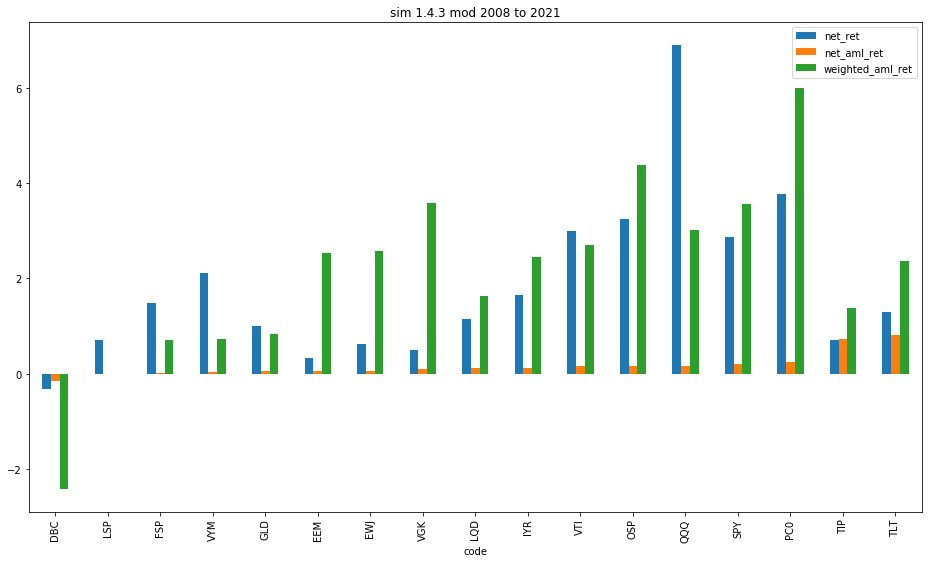

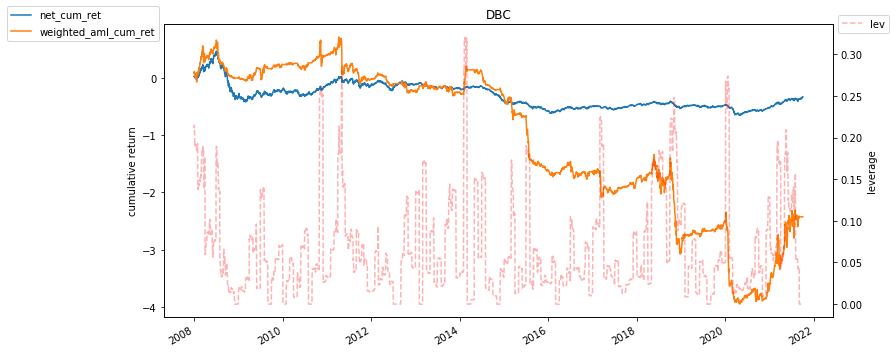

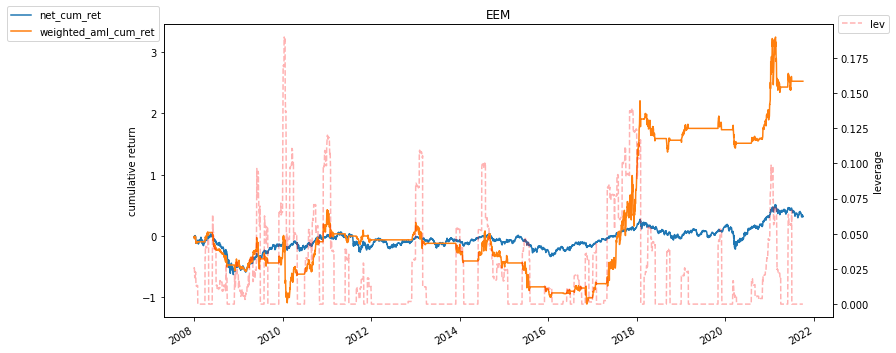

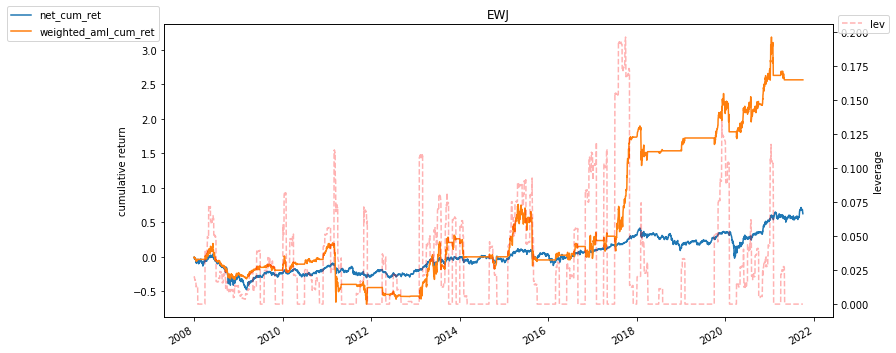

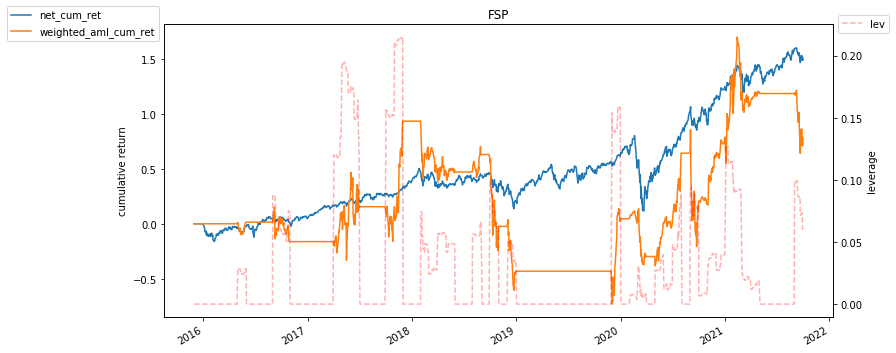

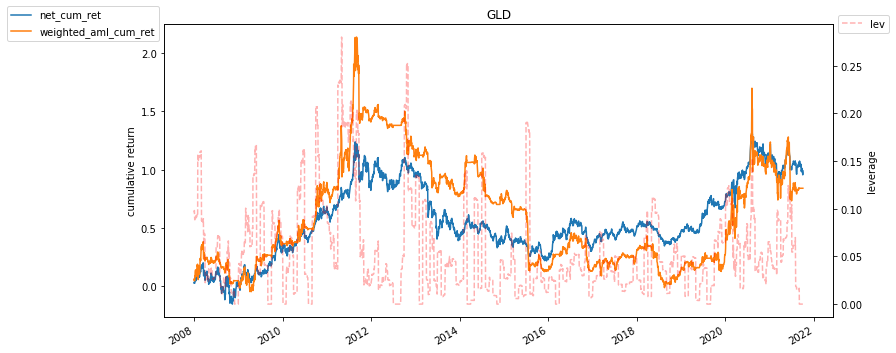

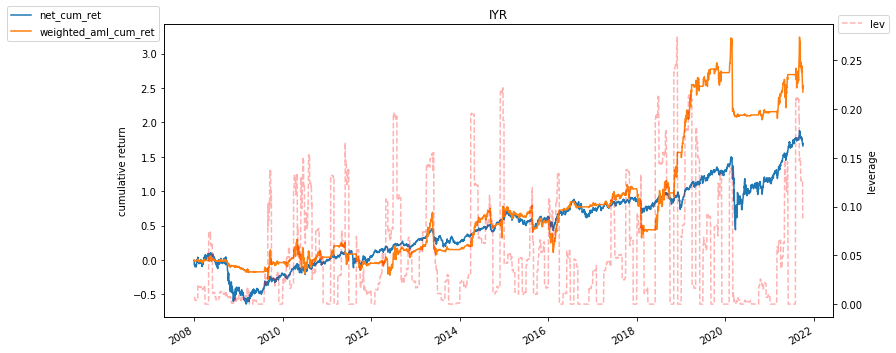

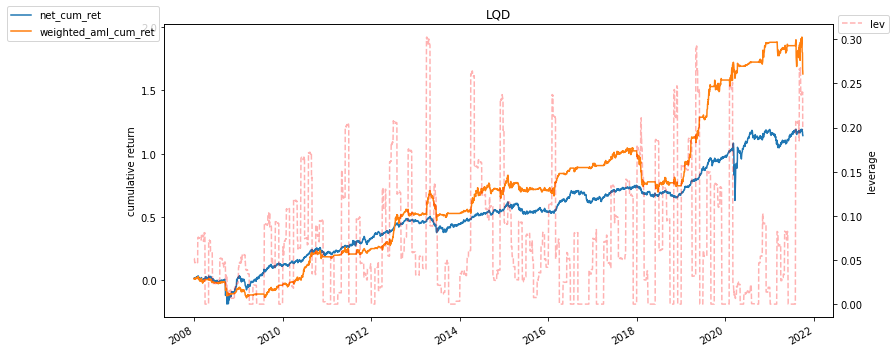

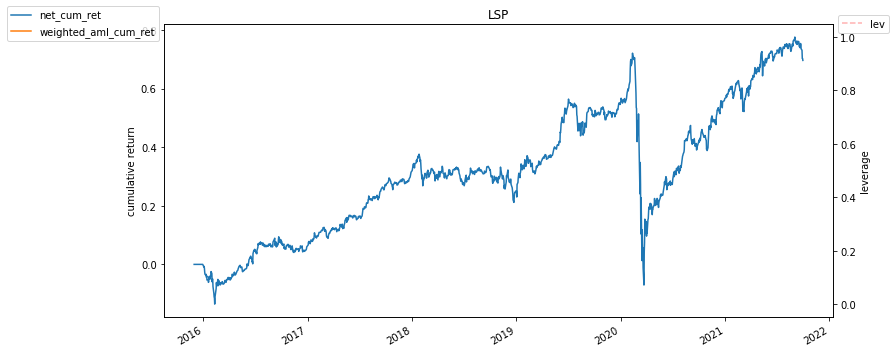

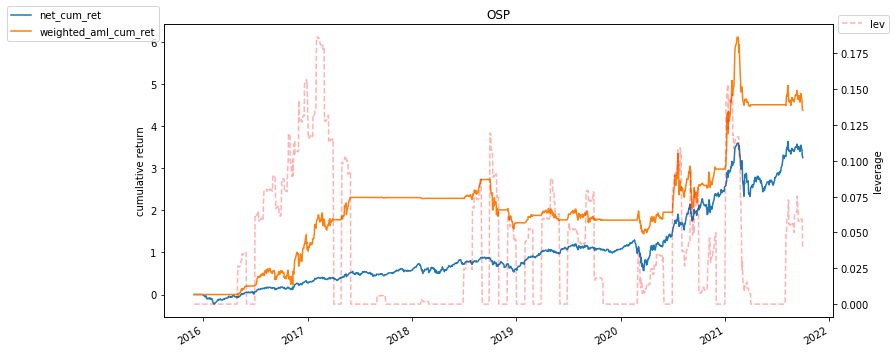

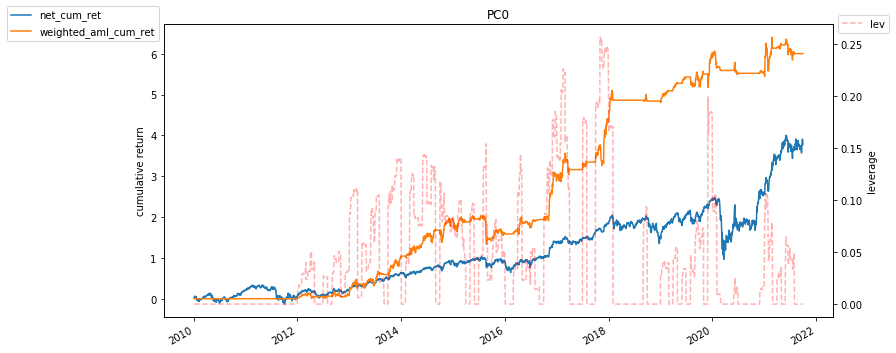

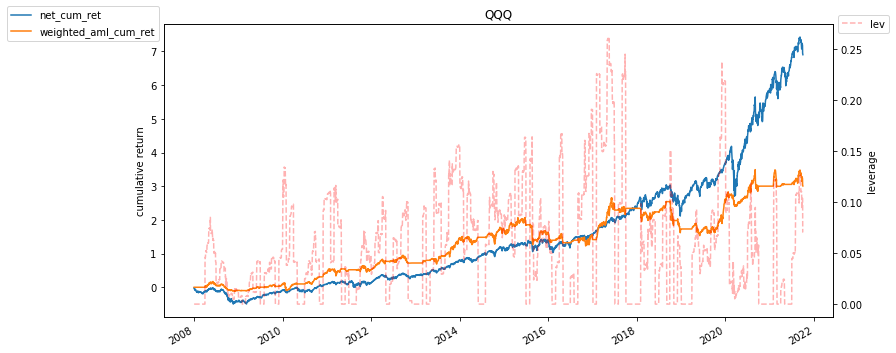

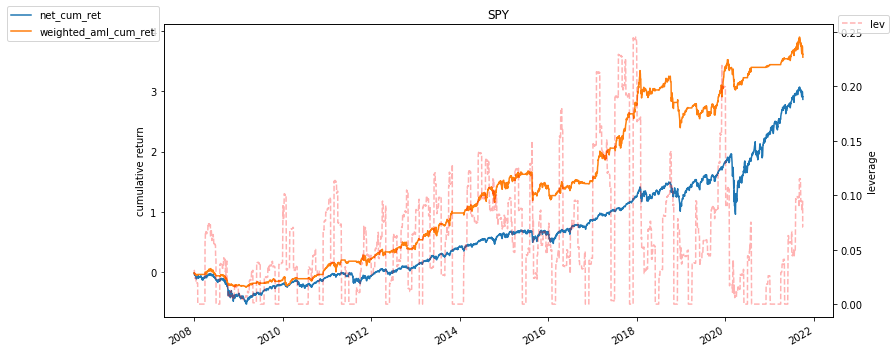

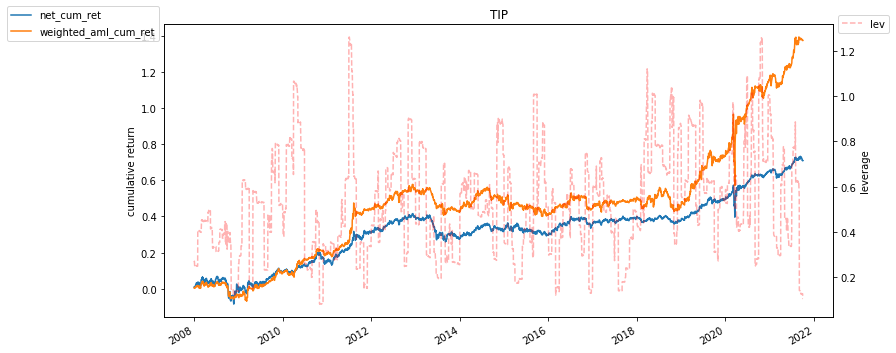

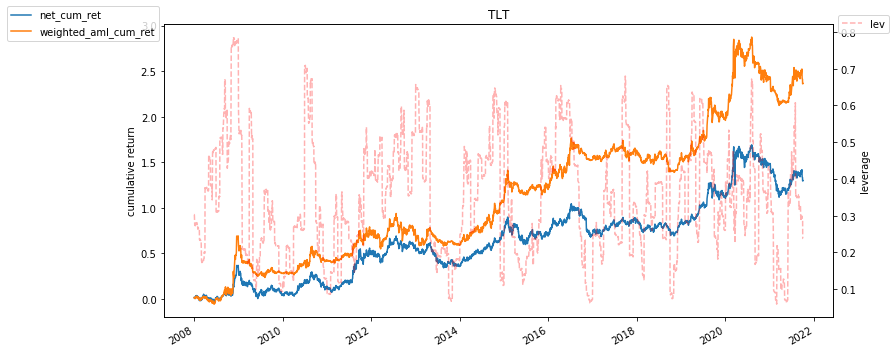

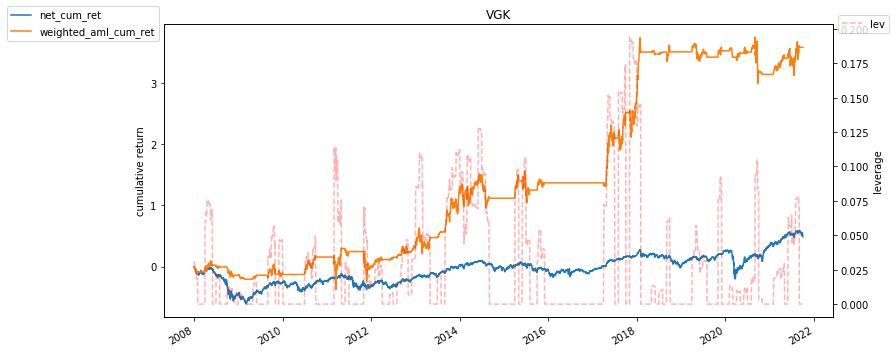

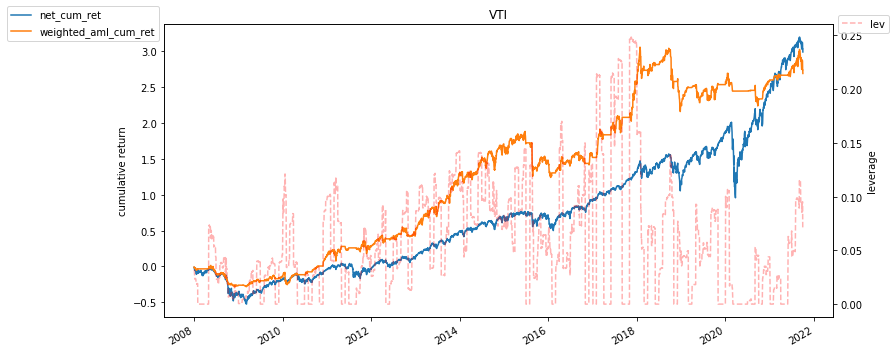

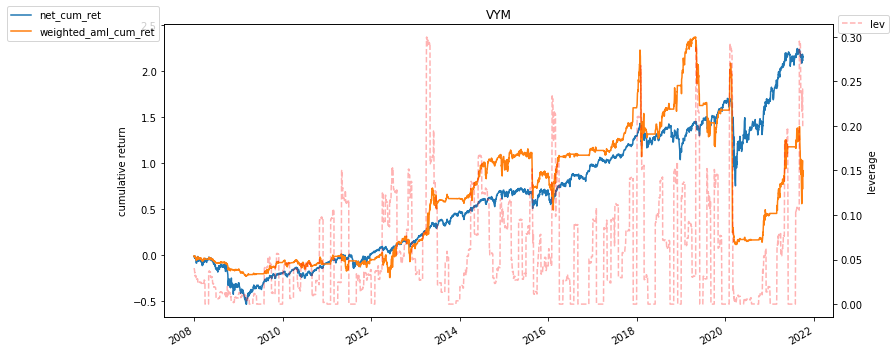

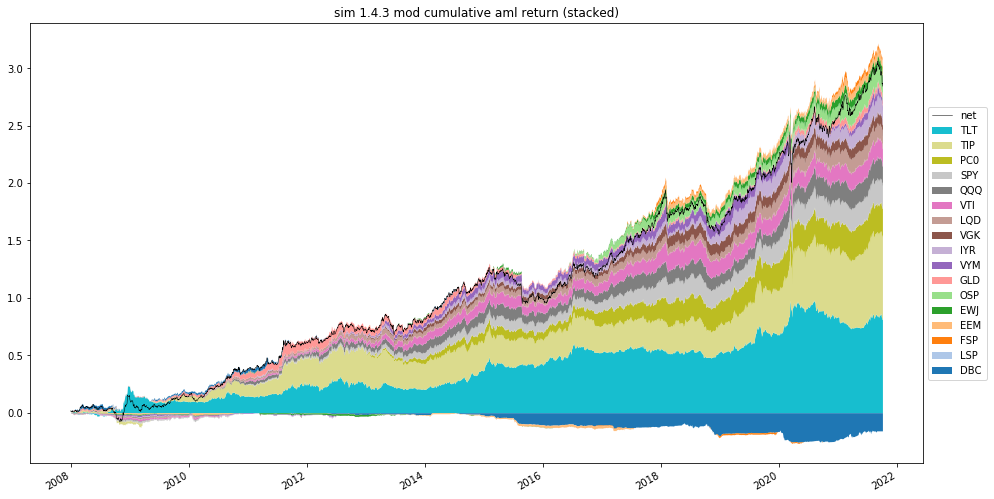

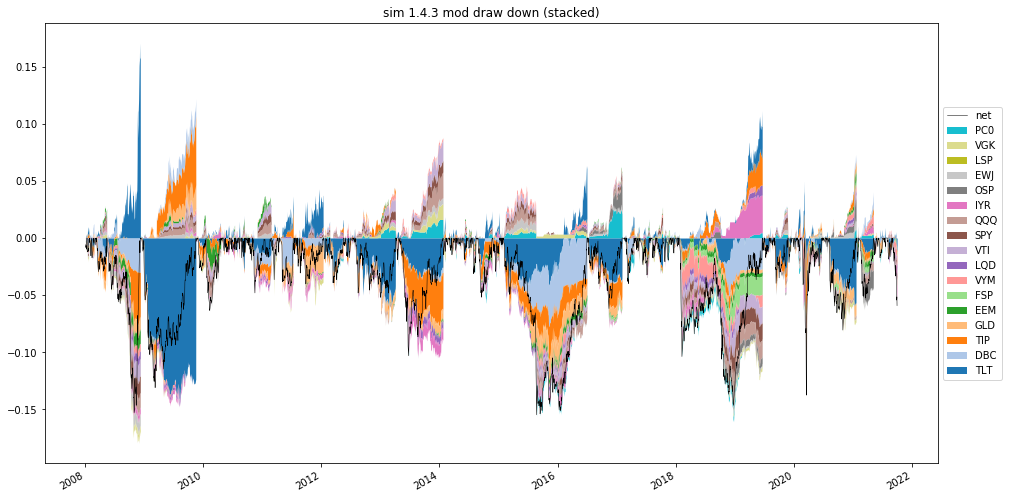

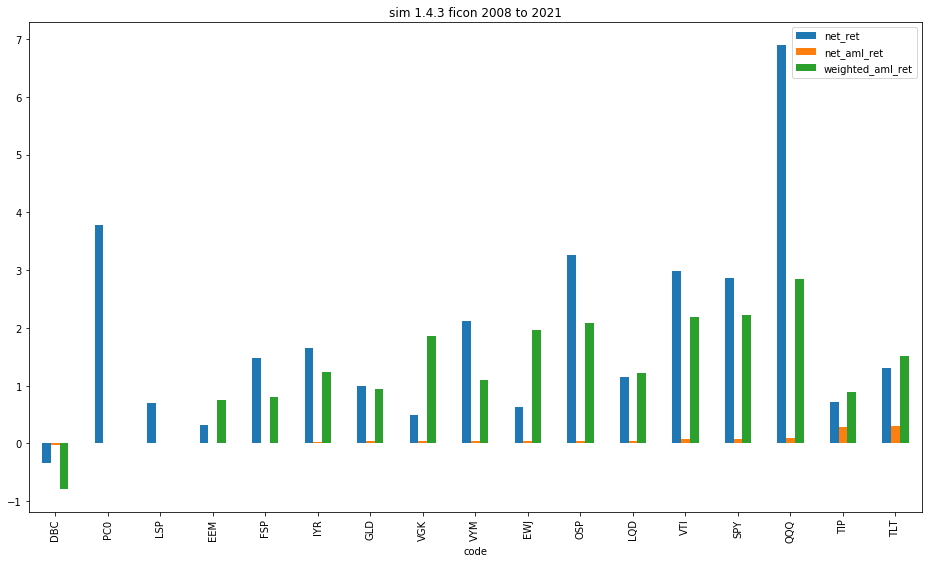

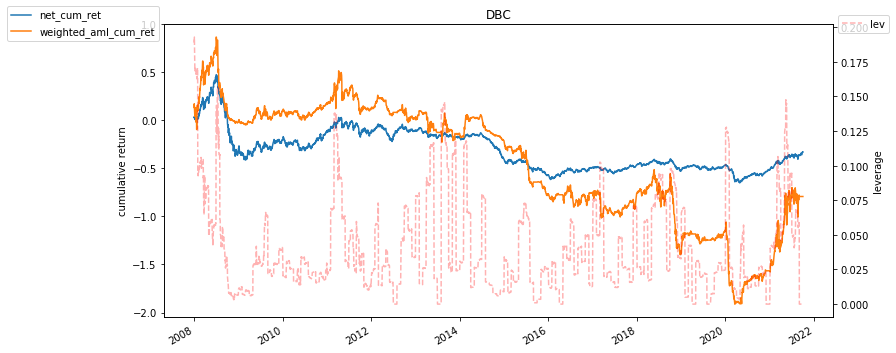

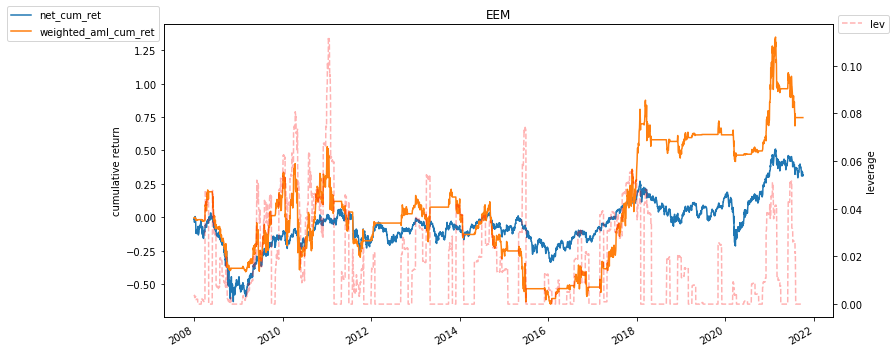

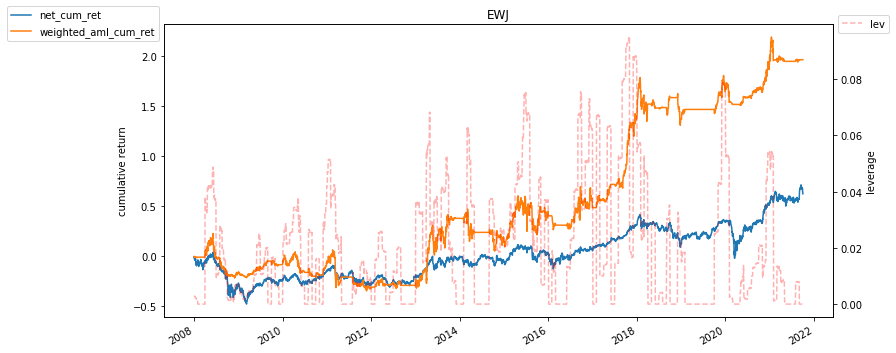

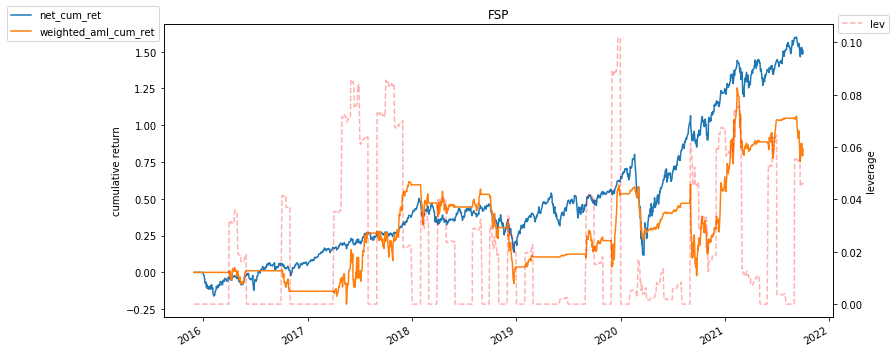

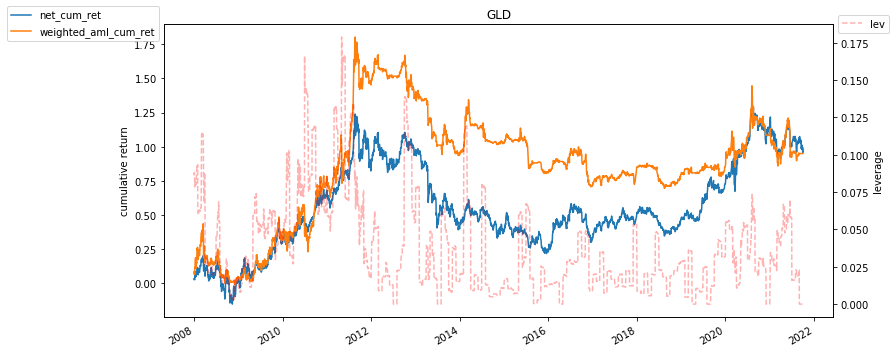

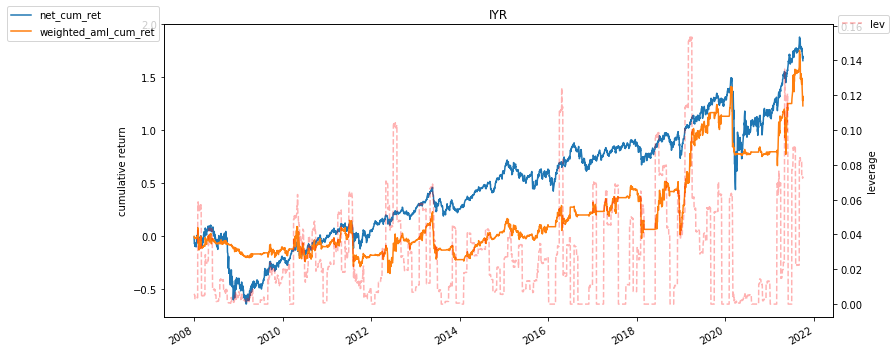

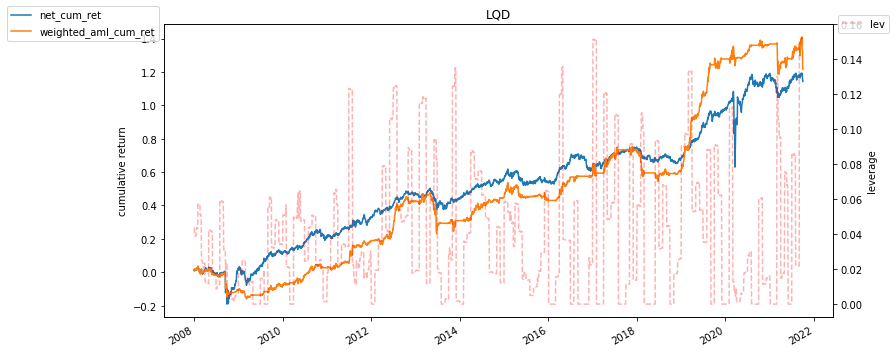

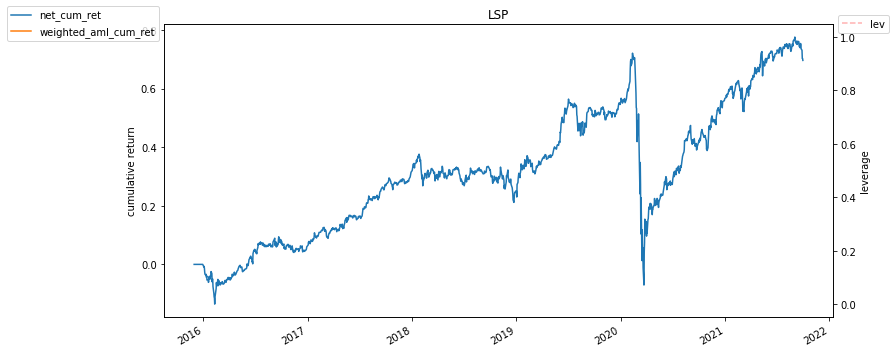

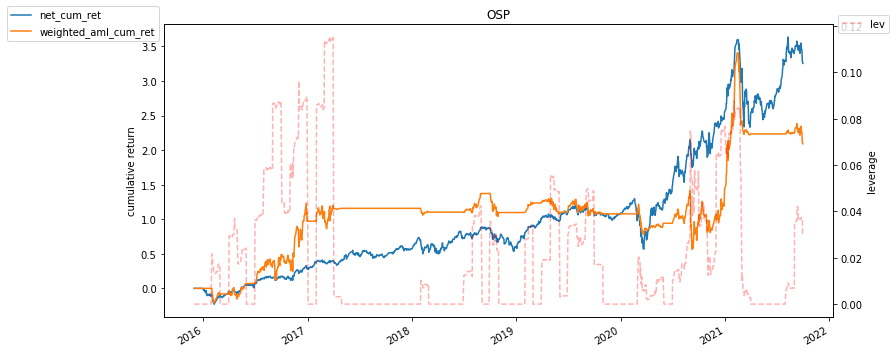

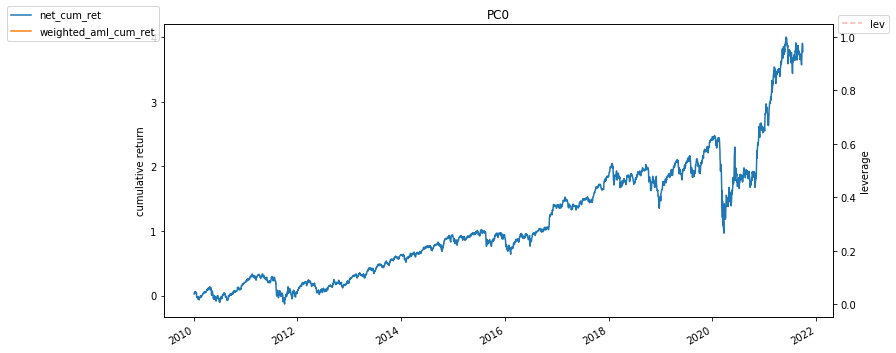

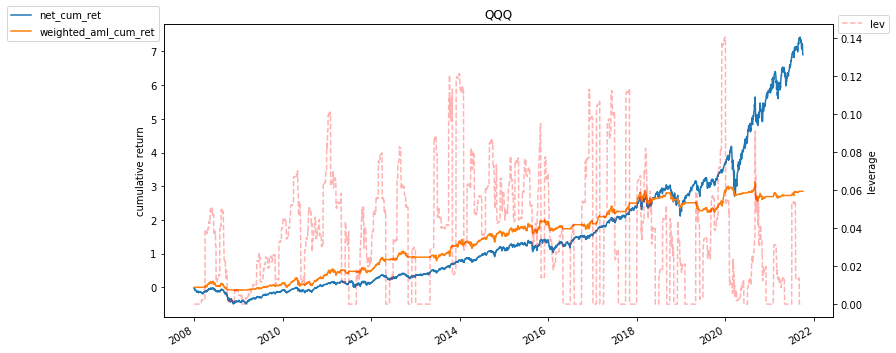

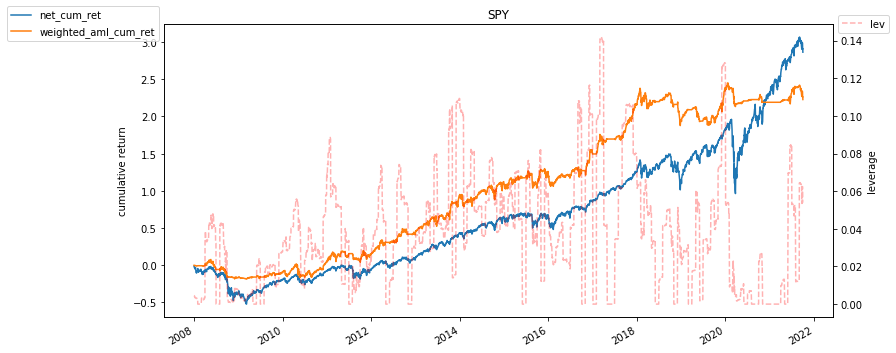

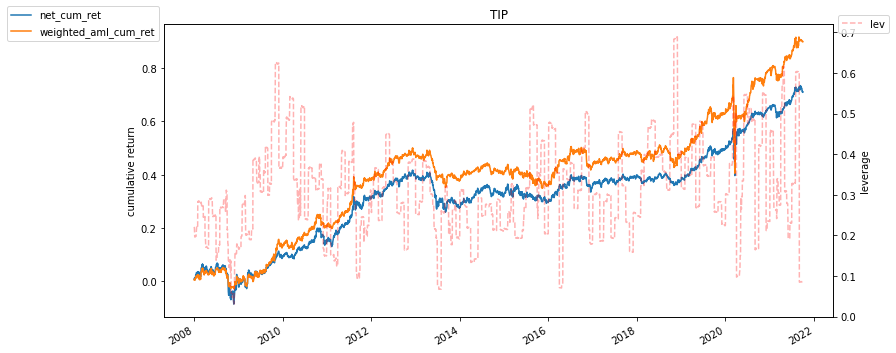

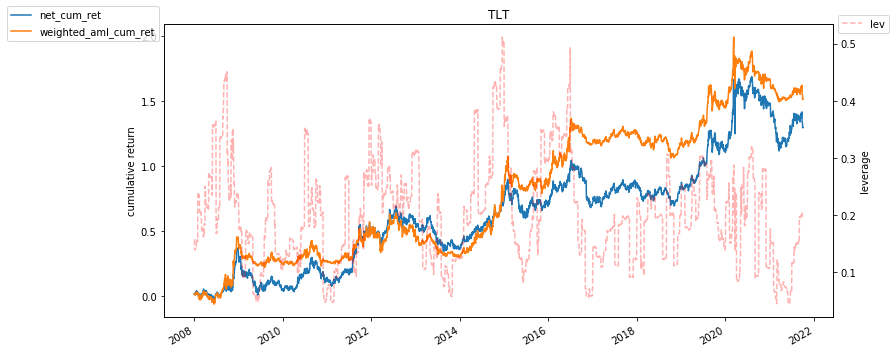

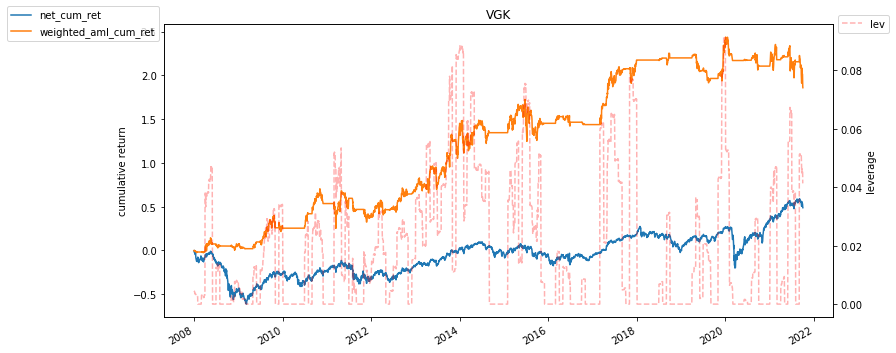

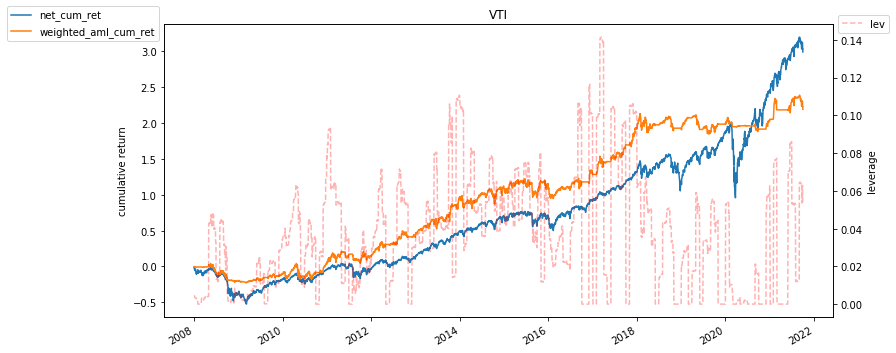

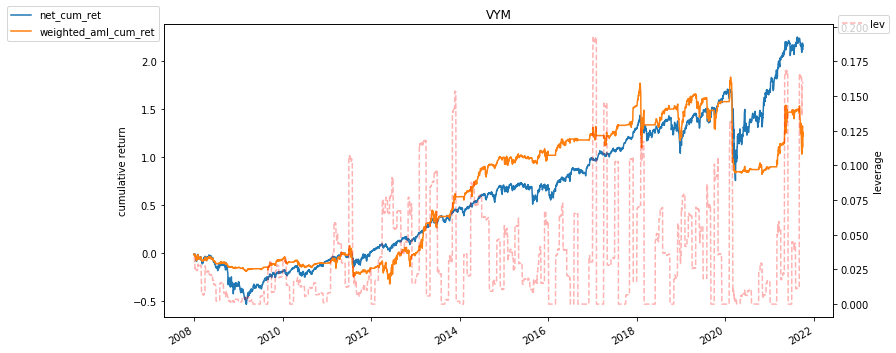

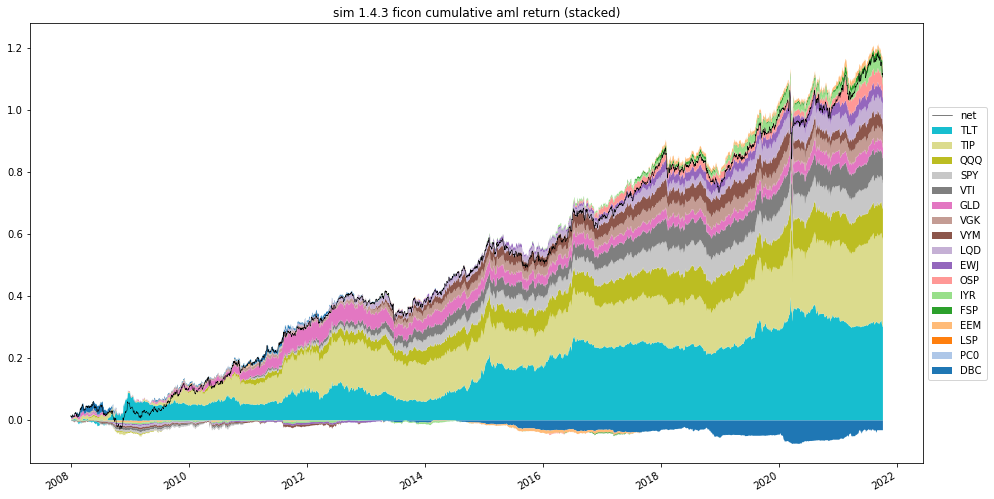

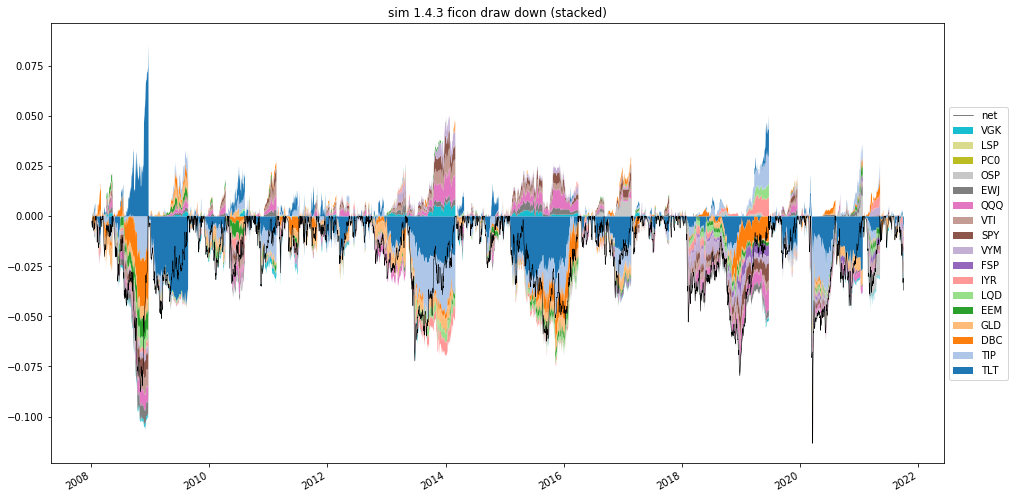

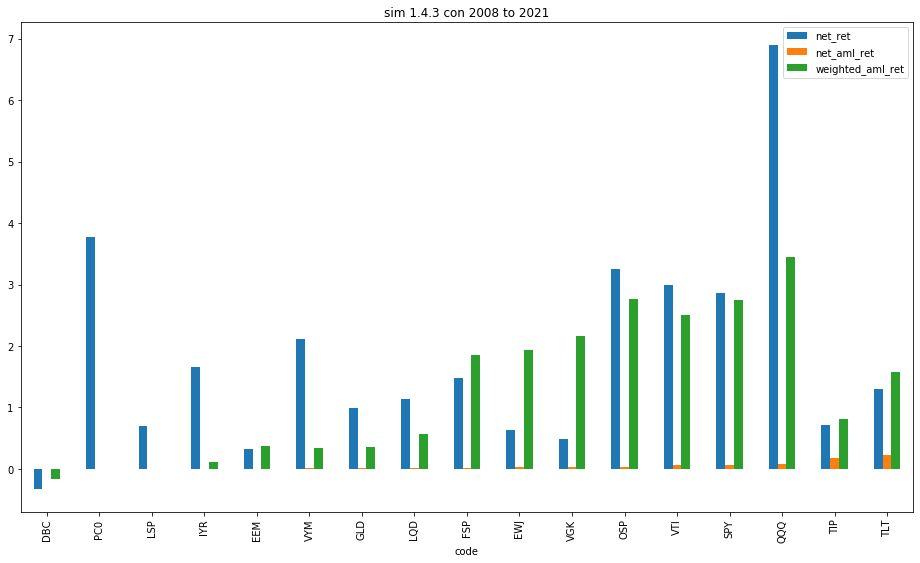

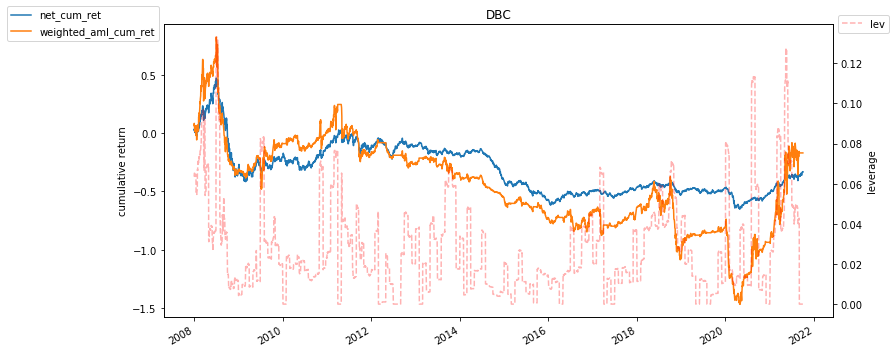

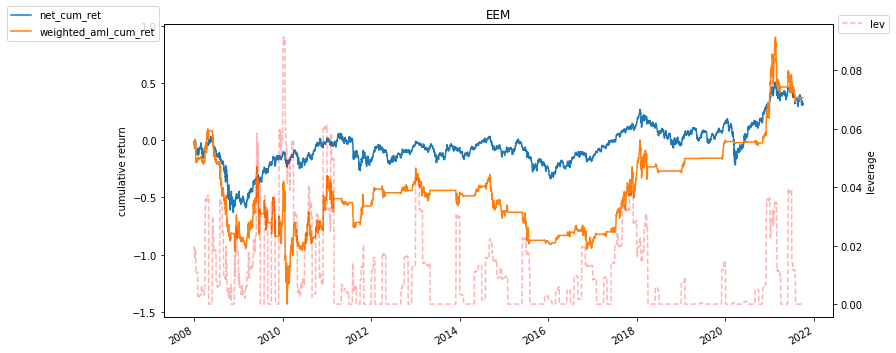

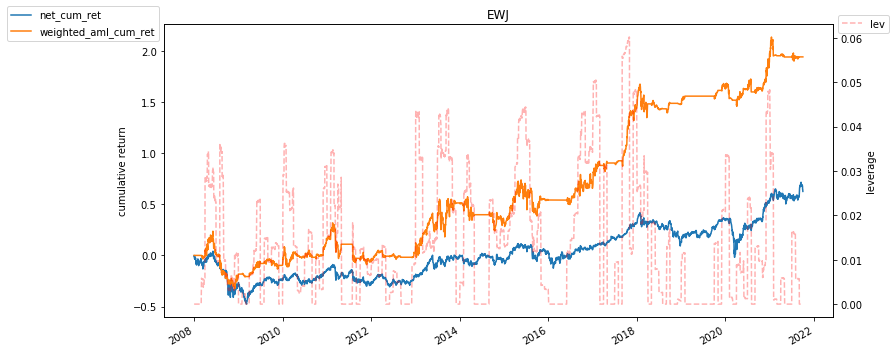

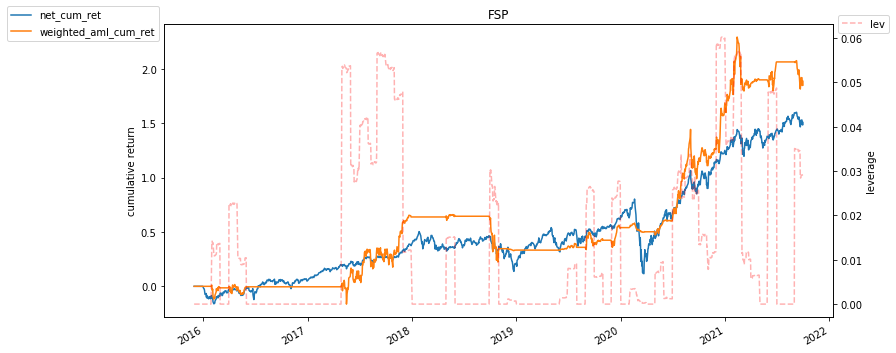

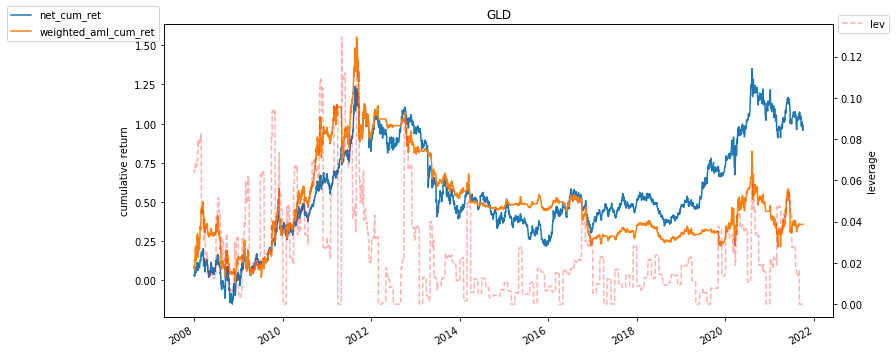

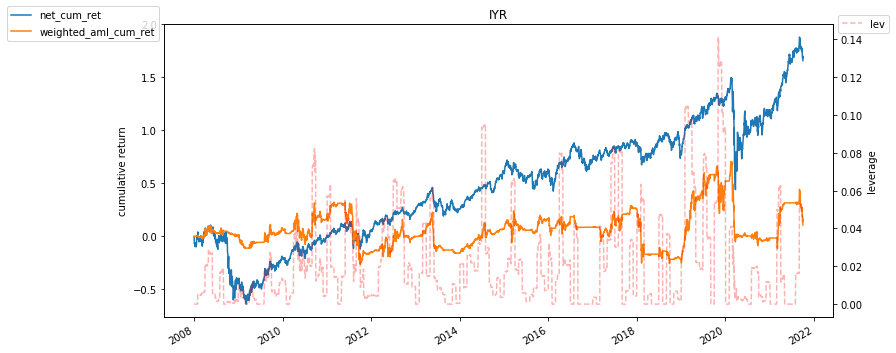

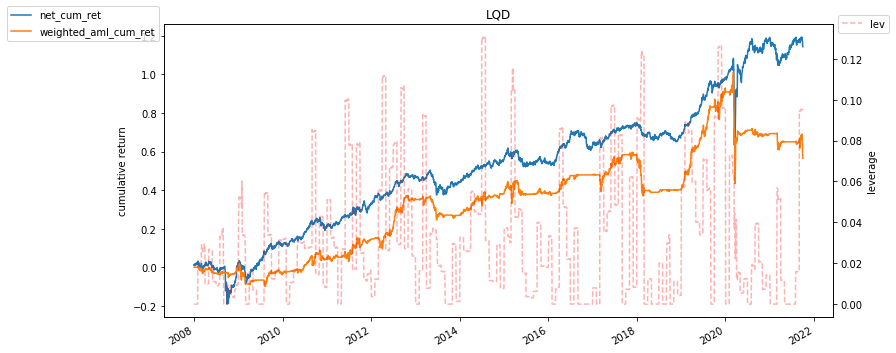

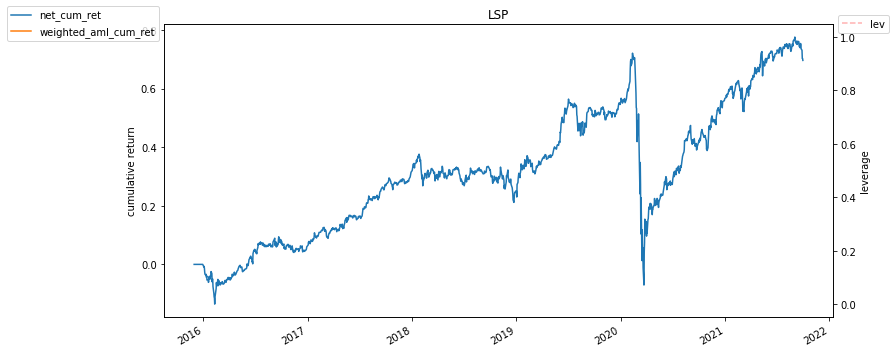

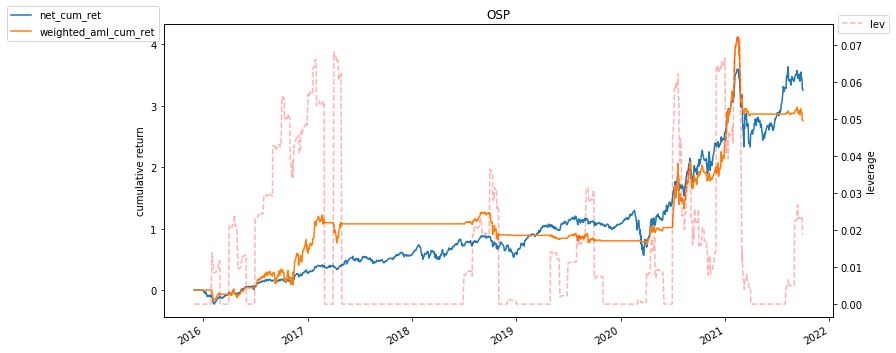

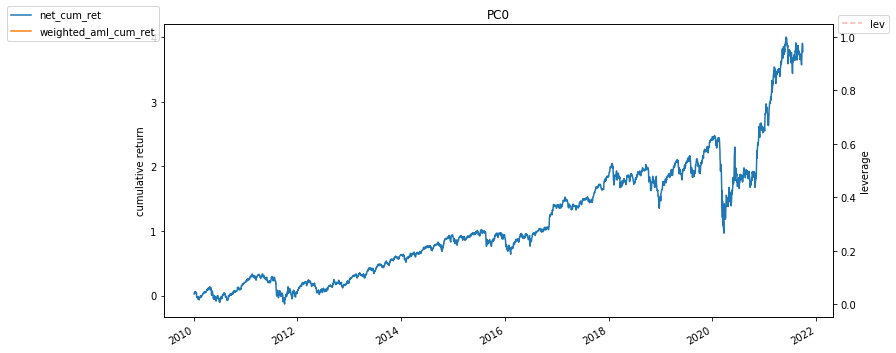

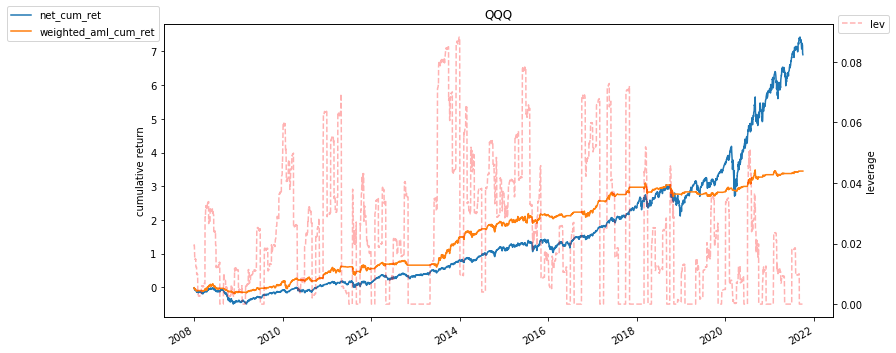

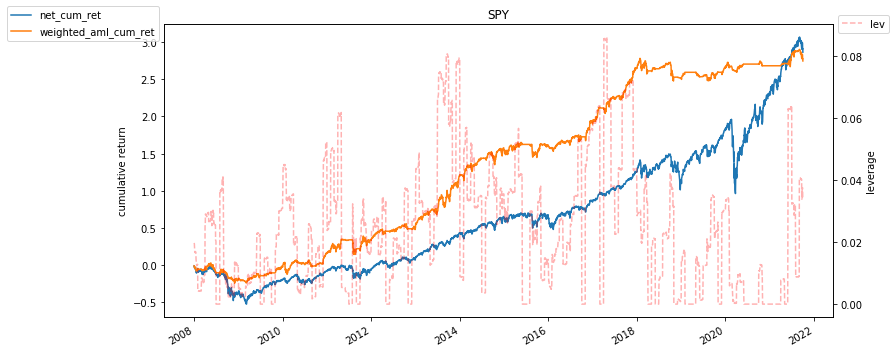

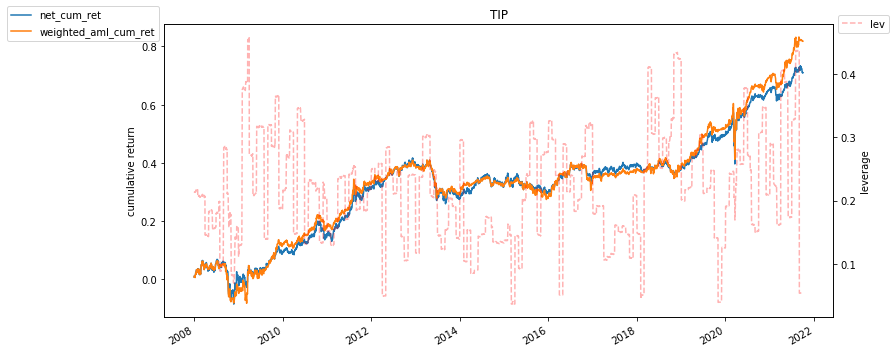

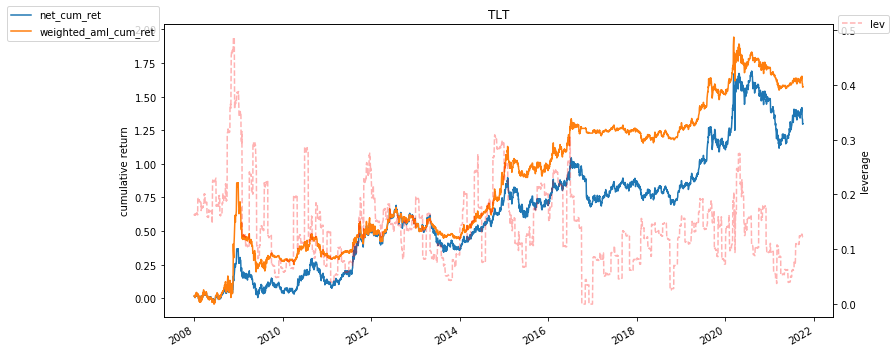

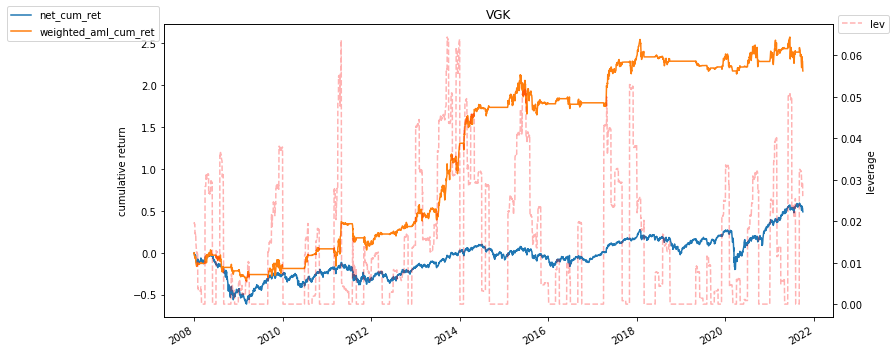

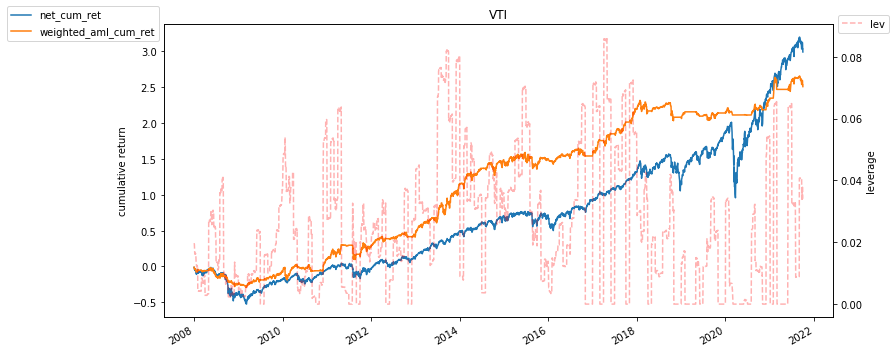

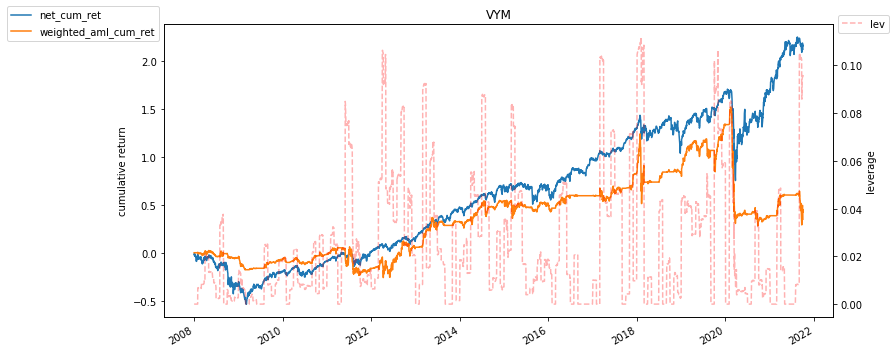

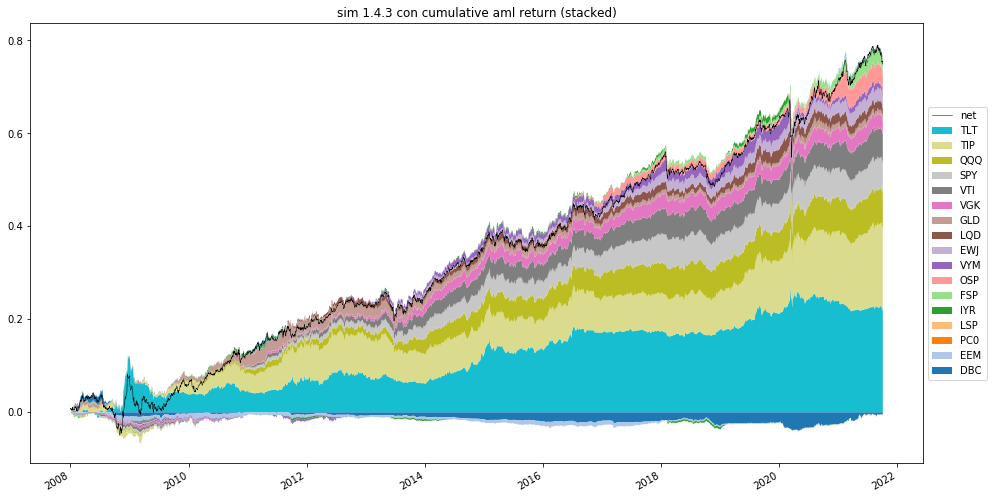

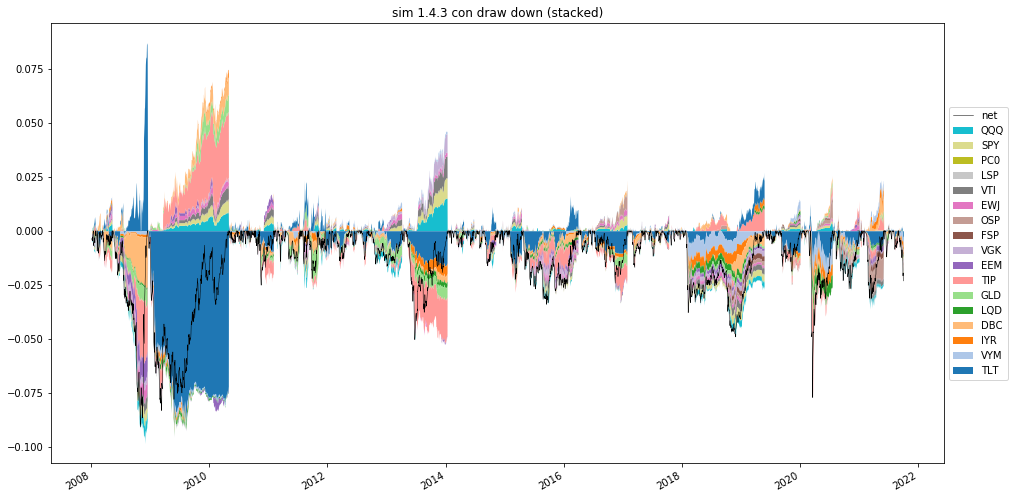

In [8]:

for n, e in zip(name_list, excel_list):
    result_all[n] = plot_all(e, ret, name=n)
    #result_all[n] = plot_all(e, ret, ini='2011', start='2012', name=n)



In [9]:
kpi_all = pd.concat([result_all[n]['kpi'] for n in name_list], 1, keys=name_list)
kpi_all

sim 1.4.3 agg sim 1.4.3 mod sim 1.4.3 ficon sim 1.4.3 con
                            KPI           KPI             KPI           KPI
Total Return           5.056571      2.550622        1.091568      0.741173
Annual Return          0.140088      0.096622        0.055182      0.041192
Annual Volatility      0.130701      0.093743        0.056072      0.042031
Sharpe                 1.068749      1.030955        0.986085      0.981486
Sortino                1.539029      1.485938        1.391685      1.417422
Calmar                 0.638875      0.637563        0.509156      0.470610
Max-DD                -0.219274     -0.151549       -0.108379     -0.087530
Downside Risk          0.090763      0.065040        0.039730      0.029104
Omega                  1.197765      1.193292        1.183863      1.189166
Tail                   1.040611      1.017978        0.981081      0.999043
R-squared              0.978806      0.971121        0.983033      0.987388
VaR                   -0.012348     -0.008828       -0.005470     -0.003956
CVaR                  -0.018662     -0.013405       -0.008098     -0.006056
Growth(+)              0.550260      0.553726        0.554593      0.553437
Growth(-)              0.449740      0.446274        0.445407      0.446563
Growth(0)              0.000000      0.000000        0.000000      0.000000
DD-Duration          557.000000    557.000000      510.000000    497.000000
Mean Leverage          2.105490      1.460652        0.864444      0.601471

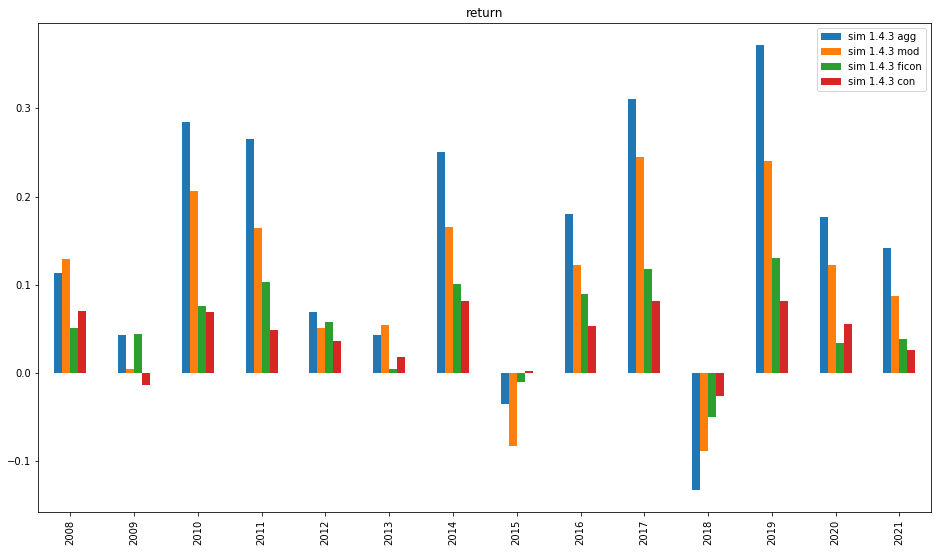

In [10]:
ykpi_ret_all = pd.concat([result_all[n]['ykpi']['Annual Return'] for n in name_list], 1, keys=name_list)
ykpi_ret_all.plot.bar(figsize=(16,9), title='return')

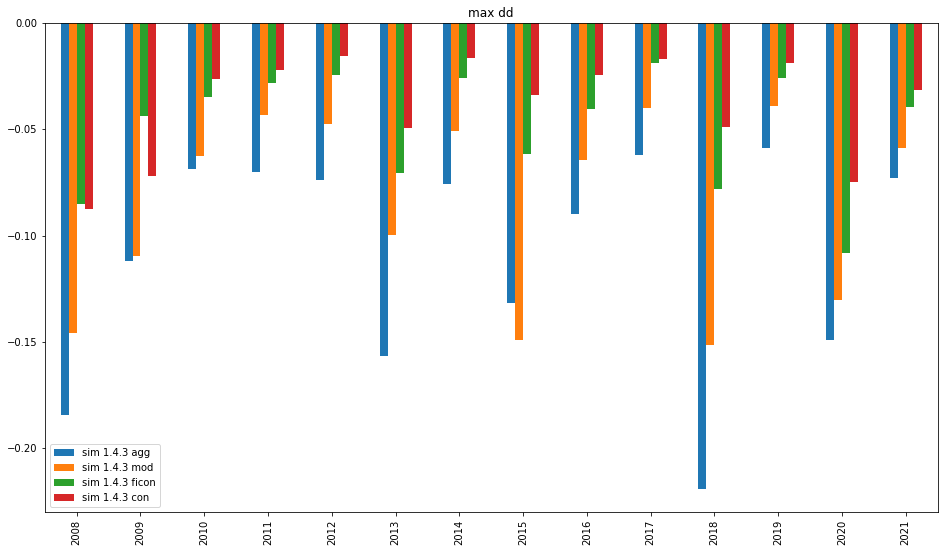

In [11]:
ykpi_mdd_all = pd.concat([result_all[n]['ykpi']['Max-DD'] for n in name_list], 1, keys=name_list)
ykpi_mdd_all.plot.bar(figsize=(16,9), title='max dd')

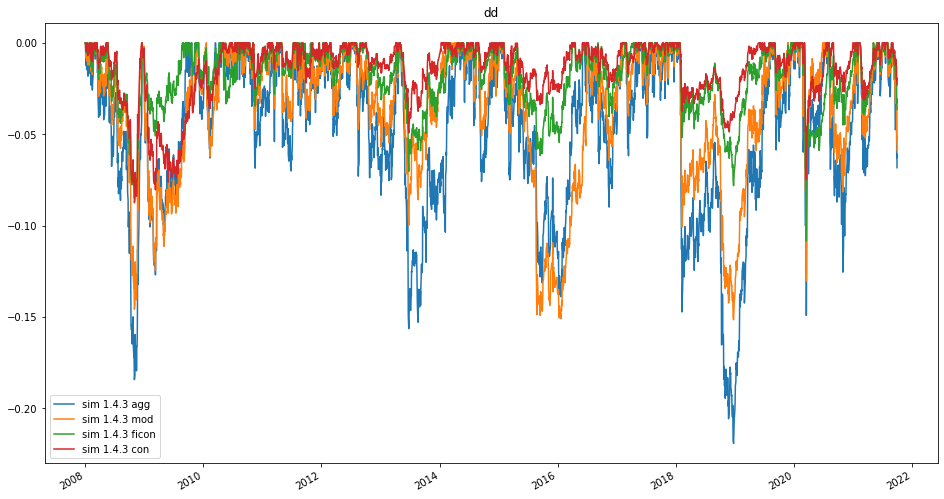

In [12]:
dkpi_dd_all = pd.concat([result_all[n]['dkpi']['Draw Down'] for n in name_list], 1, keys=name_list)
dkpi_dd_all.plot(figsize=(16,9), title='dd')

In [13]:
#dkpi_dd_all.iloc[:,[2,4]].plot(figsize=(16,9), title='dd')

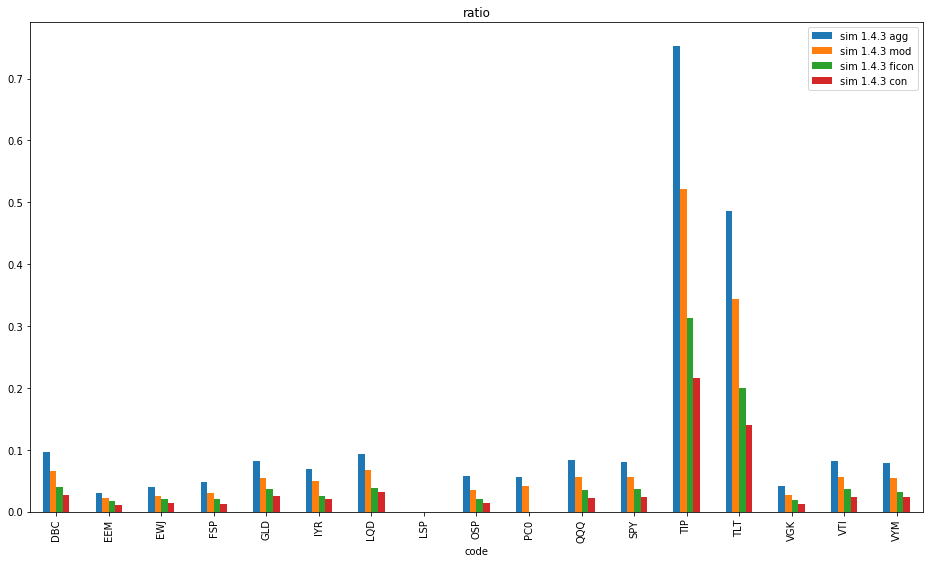

In [14]:
aml_ratio = pd.concat([result_all[n]['lev'].mean() for n in name_list], 1, keys=name_list)
aml_ratio.plot.bar(title='ratio', figsize=(16,9))


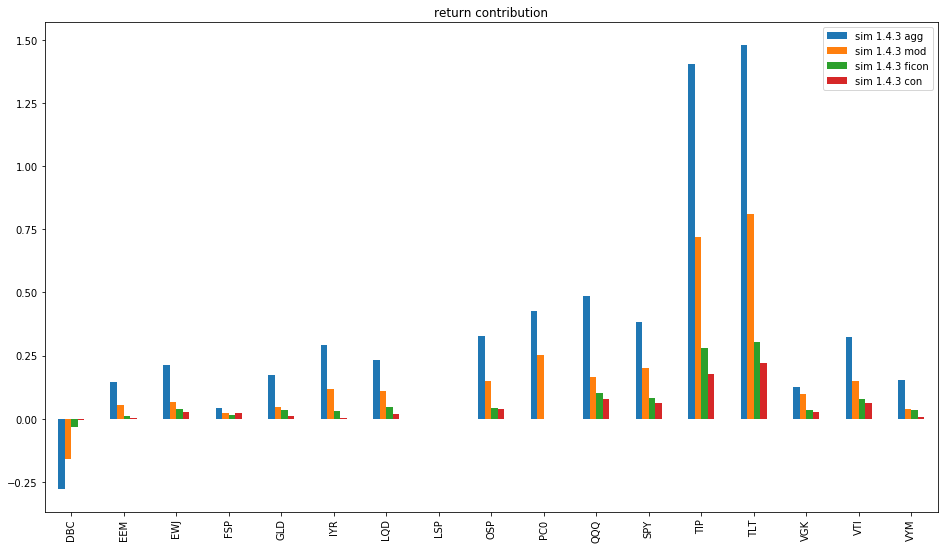

In [15]:
aml_ret_contribution = pd.concat([result_all[n]['net_aml_cum_ret_df'].iloc[-1] for n in name_list], 1, keys=name_list)


aml_ret_contribution.plot.bar(title='return contribution', figsize=(16,9))





In [16]:
aml_ret_contribution.sum()

sim 1.4.3 agg      5.929957
sim 1.4.3 mod      2.844309
sim 1.4.3 ficon    1.105171
sim 1.4.3 con      0.749055
dtype: float64

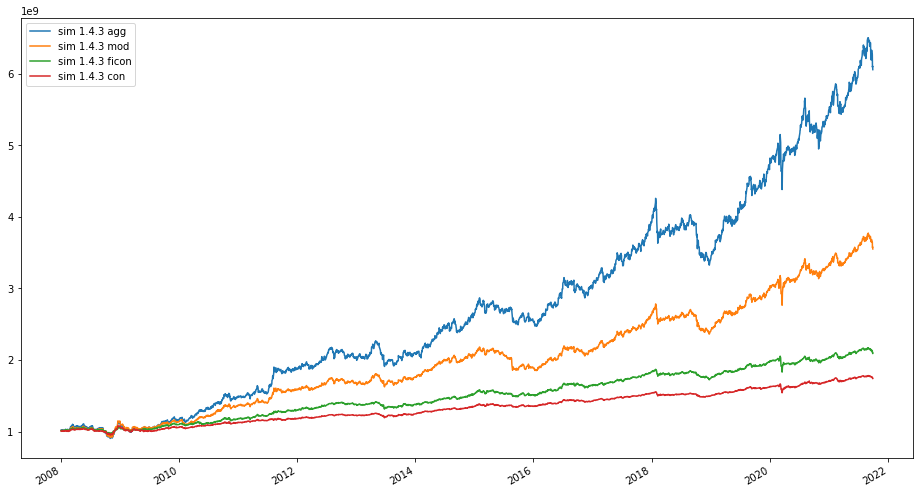

In [17]:
pd.concat([result_all[n]['balance'] for n in name_list], 1, keys=name_list).plot(figsize=(16,9))

In [18]:
import math

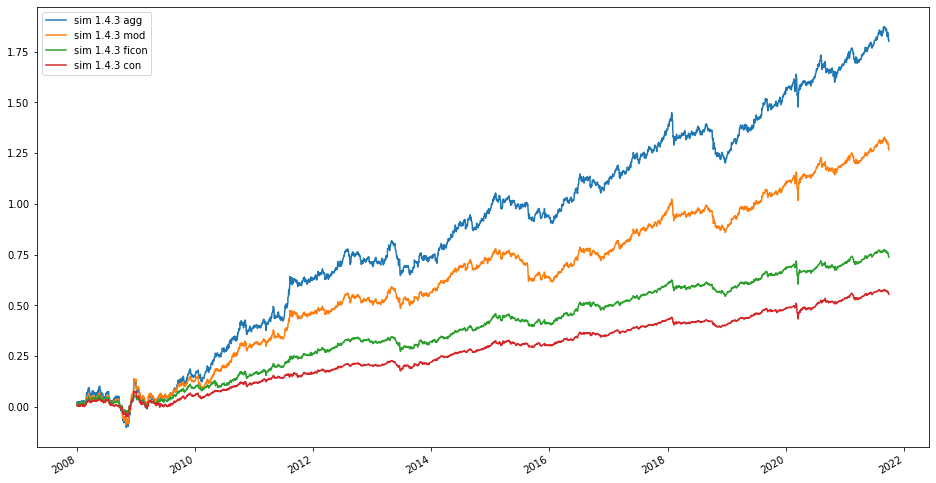

In [19]:

(pd.concat([result_all[n]['balance'] for n in name_list], 1, keys=name_list)/1e9).applymap(math.log).plot(figsize=(16,9))

In [20]:
result_all[name_list[0]]['dkpi']

Daily Return  Accumulated Prodouct  Draw Down  Leverage
2008-01-02      0.020657              1.020657   0.000000  1.668930
2008-01-03      0.004444              1.025193   0.000000  1.665971
2008-01-04     -0.008681              1.016293  -0.008681  1.671803
2008-01-07     -0.003747              1.012485  -0.012396  1.503147
2008-01-08      0.002382              1.014896  -0.010044  1.501951
...                  ...                   ...        ...       ...
2021-09-24     -0.005642              6.292132  -0.032109  1.815539
2021-09-27     -0.003535              6.269888  -0.035531  1.818432
2021-09-28     -0.028410              6.091759  -0.062932  1.852303
2021-09-29      0.002295              6.105739  -0.060781  1.536711
2021-09-30     -0.008053              6.056571  -0.068344  1.542710

[3462 rows x 4 columns]

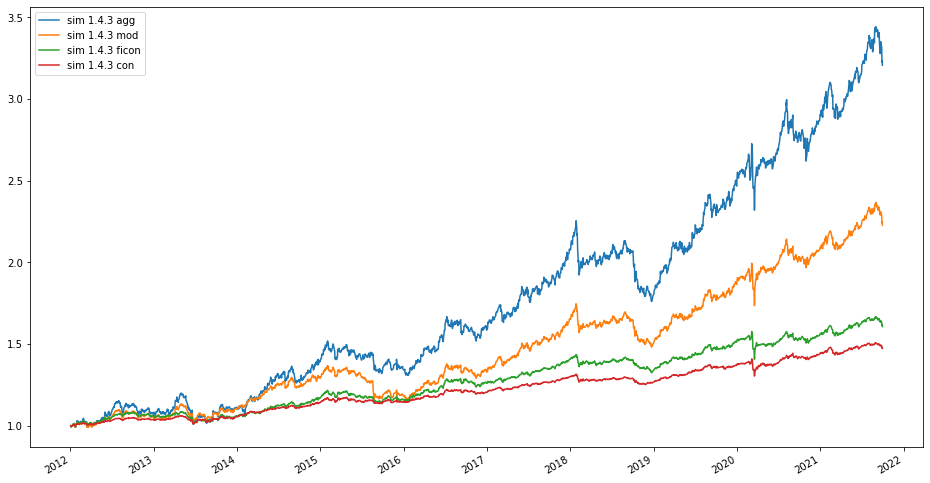

In [21]:

(1+pd.concat([result_all[n]['dkpi']['Daily Return']['2012':] for n in name_list], 1, keys=name_list)).cumprod().plot(figsize=(16,9))

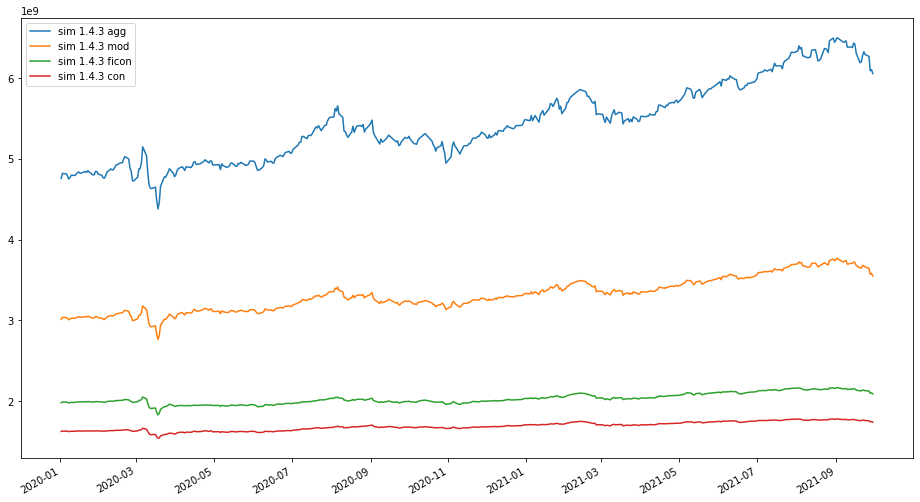

In [22]:
pd.concat([result_all[n]['balance'] for n in name_list], 1, keys=name_list)['2020':].plot(figsize=(16,9))

In [23]:
#pd.concat([result_all[n]['net_aml_cum_ret_df'].sum(1) for n in name_list], 1).plot(figsize=(16,9))

In [24]:
#pd.concat([result_all[n]['balance']/1e9 - 1 for n in name_list]
#          +[result_all[n]['net_aml_cum_ret_df'].sum(1) for n in name_list], 1).plot(figsize=(16,9))

In [25]:
'''fee_correction = pd.concat([(result_all[n]['balance']/1e9 ) / (1+result_all[n]['net_aml_cum_ret_df'].sum(1)) 
                            for n in name_list], 1).squeeze()
fee_correction'''

"fee_correction = pd.concat([(result_all[n]['balance']/1e9 ) / (1+result_all[n]['net_aml_cum_ret_df'].sum(1)) \n                            for n in name_list], 1).squeeze()\nfee_correction"

In [26]:
#cumsum_temp.sum(1).plot()

In [27]:
'''(cumsum_temp.sum(1)*fee_correction).plot()'''

'(cumsum_temp.sum(1)*fee_correction).plot()'

In [28]:
'''pd.concat([(result_all[n]['balance']/1e9 ) / (1+result_all[n]['net_aml_cum_ret_df'].sum(1)) for n in name_list]
          , 1).plot(figsize=(16,9))'''

"pd.concat([(result_all[n]['balance']/1e9 ) / (1+result_all[n]['net_aml_cum_ret_df'].sum(1)) for n in name_list]\n          , 1).plot(figsize=(16,9))"

In [29]:
# check sum

In [30]:
#net_aml_cum_ret.sum(1).plot()

In [31]:
#(allo.Balance/balance_ini-1).plot()

In [32]:
#(allo.Balance/balance_ini-1-net_aml_cum_ret.sum(1)).plot()